In [1]:
import numpy as np
import torch
import pyepo

Auto-Sklearn cannot be imported.


## Data Set and Optimization Solver

In [2]:
# generate data
num_node = 20 # node size
num_data = 1000 # number of training data
num_feat = 10 # size of feature
deg = 4 # polynomial degree
e = 0.5 # noise width
feats, costs = pyepo.data.tsp.genData(num_data+100+1000, num_feat, num_node, deg, e, seed=42)

In [3]:
from model import tspDFJModel
# set solver
optmodel = tspDFJModel(num_node)
# test
optmodel.setObj(costs[0])
sol, obj = optmodel.solve()
print("Obj: {}".format(obj))
tour = optmodel.getTour(sol)
print(" -> ".join(map(str, tour)))

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
Obj: 58.1424
0 -> 10 -> 15 -> 8 -> 5 -> 3 -> 17 -> 1 -> 6 -> 13 -> 19 -> 11 -> 18 -> 7 -> 2 -> 14 -> 12 -> 4 -> 9 -> 16 -> 0


In [4]:
# split data
from sklearn.model_selection import train_test_split
feats, x_test, costs, c_test = train_test_split(feats, costs, test_size=1000, random_state=42)
x_train, x_val, c_train, c_val = train_test_split(feats, costs, test_size=100, random_state=42)

In [5]:
# get training, validation and test dataset
dataset_train_cost = pyepo.data.dataset.optDataset(optmodel, x_train, costs=c_train)
dataset_val = pyepo.data.dataset.optDataset(optmodel, x_val, costs=c_val)
dataset_test = pyepo.data.dataset.optDataset(optmodel, x_test, costs=c_test)

Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 128.64it/s]


Optimizing for optDataset...


100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 134.40it/s]


Optimizing for optDataset...


100%|█████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 132.12it/s]


In [6]:
from dataset import optDatasetConstrs
dataset_train = optDatasetConstrs(optmodel, x_train, costs=c_train)

Optimizing for optDataset...


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 57.66it/s]


In [7]:
# get data loader
from torch.utils.data import DataLoader
from dataset import collate_fn
batch_size = 32
loader_train_cost = DataLoader(dataset_train_cost, batch_size=batch_size, shuffle=True)
loader_train = DataLoader(dataset_train, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

## Prediction Model

In [8]:
import torch
from torch import nn

# build linear model
class LinearRegression(nn.Module):

    def __init__(self):
        super(LinearRegression, self).__init__()
        self.linear = nn.Linear(num_feat, num_node*(num_node-1)//2)

    def forward(self, x):
        out = self.linear(x)
        return out

## Plot 

In [9]:
from matplotlib import pyplot as plt

def plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step):
    # draw loss plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(loss_log, color="c", lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Loss", fontsize=36)
    plt.title("Loss Curve on Training Set", fontsize=36)
    plt.show()
    # draw grad plot for training
    plt.figure(figsize=(16, 8))
    plt.plot(grad_log, color="g", alpha=0.5, lw=2)
    plt.xticks(fontsize=28)
    plt.yticks(fontsize=28)
    plt.gca().yaxis.get_offset_text().set_size(24)
    plt.xlabel("Iters", fontsize=36)
    plt.ylabel("Abs Grad", fontsize=36)
    plt.title("Absolute Gradient Curve on Training Set", fontsize=36)
    plt.show()
    # draw regret plot for test
    fig = plt.figure(figsize=(16, 8))
    plt.plot([i * log_step for i in range(len(regret_log_trn))], regret_log_trn,
             color="royalblue", ls="--", alpha=0.7, lw=5, label="Train")
    plt.plot([i * log_step for i in range(len(regret_log_val))], regret_log_val,
             color="lightcoral", ls=":", alpha=0.7, lw=5, label="Val")
    plt.xlim(-1, num_epochs+1)
    plt.ylim(0, 0.5)
    plt.xticks(range(0, num_epochs+1, 5), fontsize=28)
    plt.yticks(fontsize=28)
    plt.xlabel("Epoch", fontsize=36)
    plt.ylabel("Regret", fontsize=36)
    plt.legend(fontsize=32)
    plt.title("Regret Curve on Training and Validation Set", fontsize=36)
    plt.show()

## Train

In [10]:
lr = 5e-2
num_epochs = 40
log_step = 2

In [11]:
import time
from tqdm import tqdm
from earlystop import earlyStopper

def pipeline(reg, forward_func, loss_func, lr, num_epochs, log_step, loader_train, loader_val, loader_test, seed=42):
    # set random seed
    np.random.seed(42)
    torch.manual_seed(42)
    # set optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # set stopper
    stopper = earlyStopper(patience=3)
    stop = False
    # init log
    loss_log = []
    grad_log = []
    regret_log_trn = []
    regret_log_val = []
    # running time
    elapsed = 0
    tbar = tqdm(range(num_epochs))
    for epoch in tbar:
        # eval & log
        if epoch % log_step == 0:
            # regret
            regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
            regret_log_trn.append(regret_trn)
            regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
            regret_log_val.append(regret_val)
            tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                       format(epoch, regret_trn*100, regret_val*100))
            # early stop
            if stopper.stop(regret_val):
                print()
                stop = True
                print("Early Stop!")
                break
        # training
        time.sleep(1)
        tick = time.time()
        for data in loader_train:
            # forward pass
            loss = forward_func(data, reg, loss_func, grad_log)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_log.append(loss.item())
            tbar.set_description("Epoch {:4.0f}, Loss: {:8.4f}".format(epoch, loss.item()))
        # record time
        tock = time.time()
        elapsed += tock - tick
    # no early stop
    if not stop:
        regret_trn = pyepo.metric.regret(reg, optmodel, loader_train_cost)
        regret_log_trn.append(regret_trn)
        regret_val = pyepo.metric.regret(reg, optmodel, loader_val)
        regret_log_val.append(regret_val)
        tbar.write("Epoch {:3}, Train Regret: {:8.4f}%, Val Regret: {:8.4f}%".
                   format(epoch, regret_trn*100, regret_val*100))
    print()
    print("Evaluation:")
    test_regret = pyepo.metric.regret(reg, optmodel, loader_test)
    print("Test Regret: {:.4f}%".format(test_regret*100))
    print("Training Elapsed Time: {:.2f} Sec".format(elapsed))
    return loss_log, grad_log, regret_log_trn, regret_log_val

def forwardCAVE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, _, t_ctr = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, t_ctr)
    return loss

### 2-Stage 

In [12]:
# init model
reg = LinearRegression()

In [13]:
from torch import nn
# init loss
mse = nn.MSELoss()

def forward2S(data, reg, loss_func, grad_log):
    # unzip data
    x, c, w, z = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, c)
    return loss

In [14]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forward2S, mse, lr, num_epochs, log_step,
                                                              loader_train_cost, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 197.5482%, Val Regret: 203.1682%


Epoch    1, Loss:  29.5987:   5%|██▊                                                    | 2/40 [00:21<03:13,  5.08s/it]

Epoch   2, Train Regret:  22.5005%, Val Regret:  23.3596%


Epoch    3, Loss:  10.7819:  10%|█████▌                                                 | 4/40 [00:32<03:00,  5.00s/it]

Epoch   4, Train Regret:  19.6059%, Val Regret:  19.8516%


Epoch    5, Loss:  11.5609:  15%|████████▎                                              | 6/40 [00:43<02:45,  4.87s/it]

Epoch   6, Train Regret:  16.6021%, Val Regret:  17.2974%


Epoch    7, Loss:   7.2829:  20%|███████████                                            | 8/40 [00:55<02:33,  4.79s/it]

Epoch   8, Train Regret:  14.6943%, Val Regret:  15.5855%


Epoch    9, Loss:   9.6684:  25%|█████████████▌                                        | 10/40 [01:06<02:27,  4.91s/it]

Epoch  10, Train Regret:  13.5464%, Val Regret:  14.3809%


Epoch   11, Loss:   8.1705:  30%|████████████████▏                                     | 12/40 [01:17<02:16,  4.87s/it]

Epoch  12, Train Regret:  13.2563%, Val Regret:  13.5573%


Epoch   13, Loss:   8.5571:  35%|██████████████████▉                                   | 14/40 [01:28<02:04,  4.78s/it]

Epoch  14, Train Regret:  13.2956%, Val Regret:  13.5528%


Epoch   15, Loss:   6.2384:  40%|█████████████████████▌                                | 16/40 [01:39<01:54,  4.76s/it]

Epoch  16, Train Regret:  13.1851%, Val Regret:  13.7006%


Epoch   17, Loss:   7.3806:  45%|████████████████████████▎                             | 18/40 [01:50<02:14,  6.13s/it]


Epoch  18, Train Regret:  13.1688%, Val Regret:  13.5636%

Early Stop!

Evaluation:
Test Regret: 13.4643%
Training Elapsed Time: 1.80 Sec


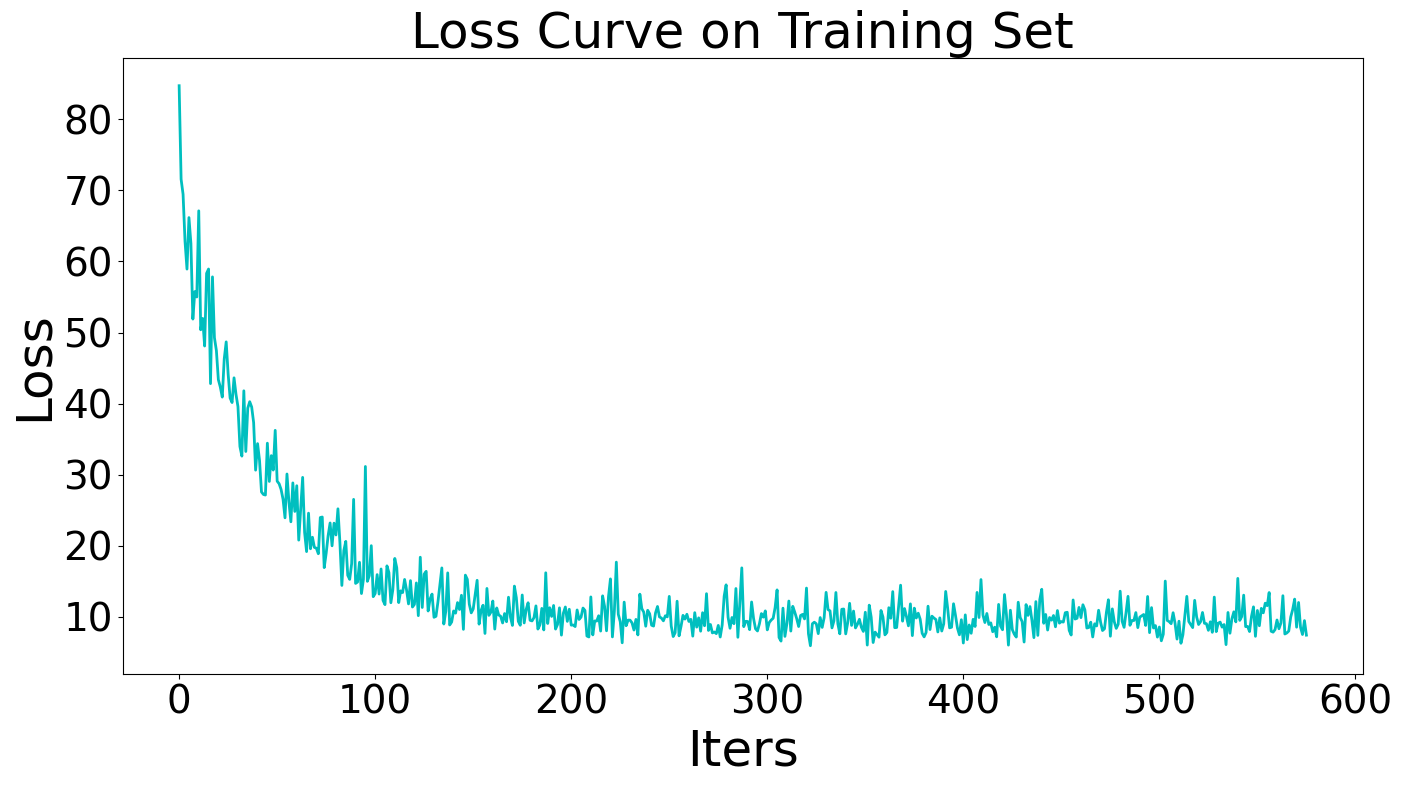

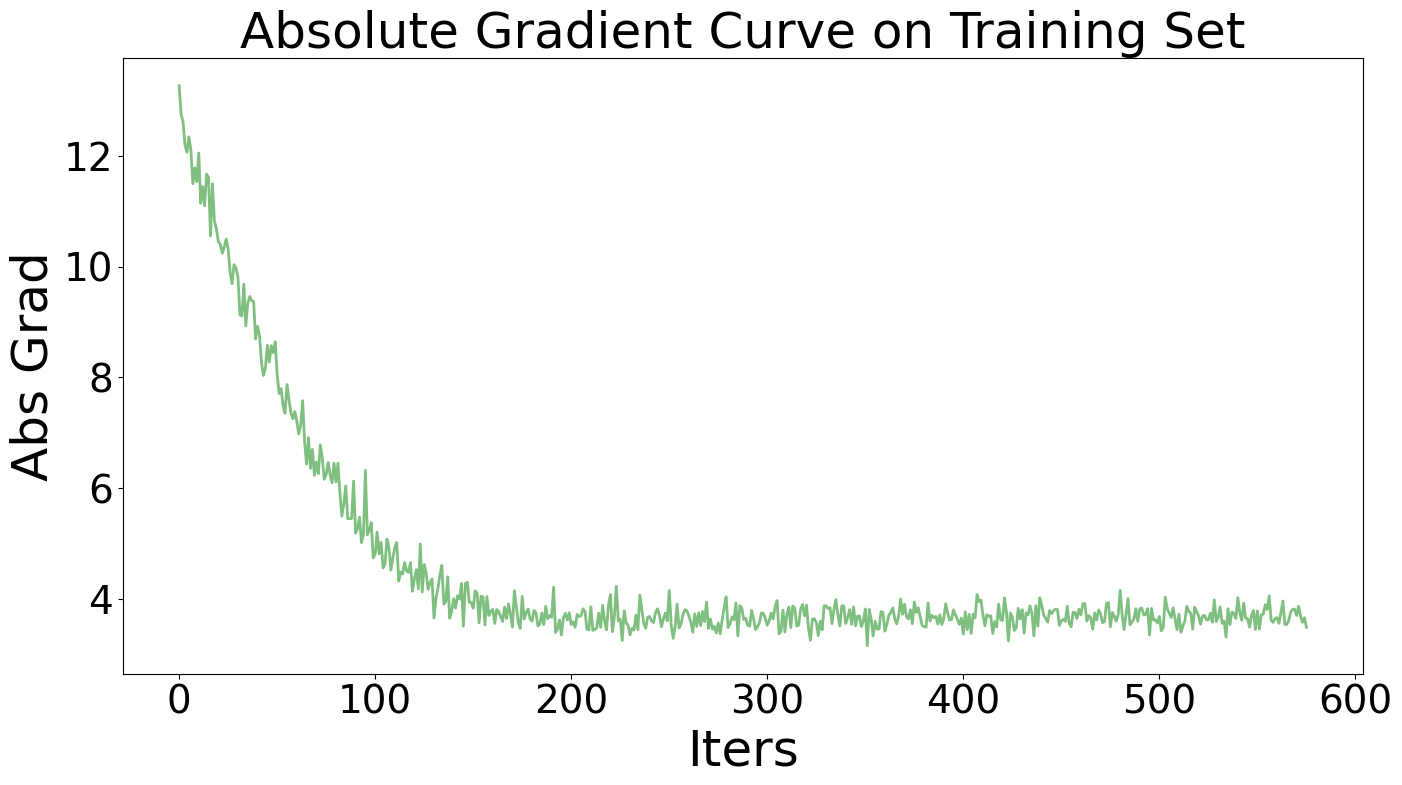

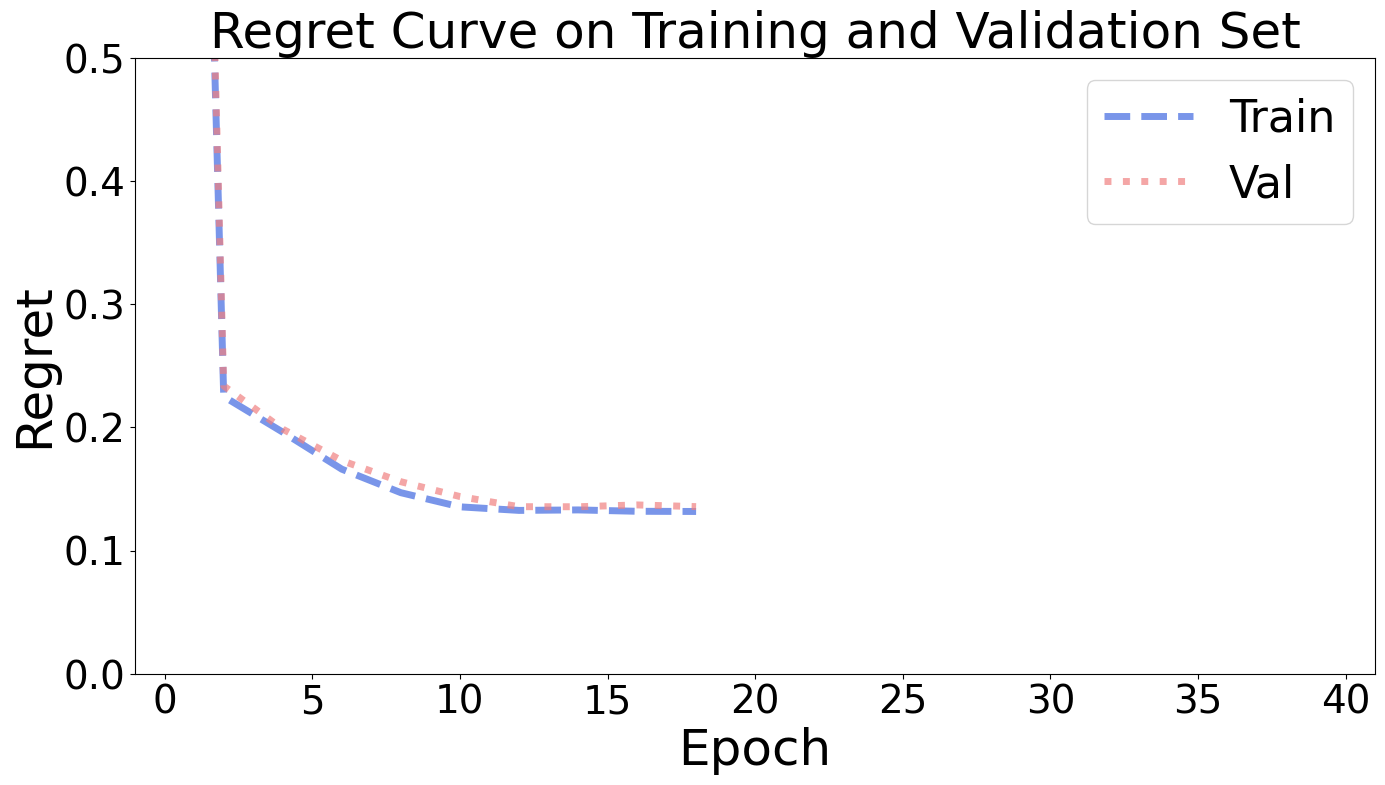

In [15]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with Clarabel

In [16]:
# init model
reg = LinearRegression()

In [17]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="clarabel", processes=8)

Num of cores: 8


In [18]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 212.4183%, Val Regret: 213.3267%


Epoch    1, Loss:  -0.9990:   5%|██▊                                                    | 2/40 [00:29<05:44,  9.06s/it]

Epoch   2, Train Regret:   8.1511%, Val Regret:   9.1031%


Epoch    3, Loss:  -0.9994:  10%|█████▌                                                 | 4/40 [00:45<04:37,  7.70s/it]

Epoch   4, Train Regret:   7.1403%, Val Regret:   7.7656%


Epoch    5, Loss:  -0.9995:  15%|████████▎                                              | 6/40 [01:00<04:06,  7.24s/it]

Epoch   6, Train Regret:   6.9356%, Val Regret:   7.4087%


Epoch    7, Loss:  -0.9991:  20%|███████████                                            | 8/40 [01:16<03:46,  7.08s/it]

Epoch   8, Train Regret:   6.8537%, Val Regret:   7.4126%


Epoch    9, Loss:  -0.9993:  25%|█████████████▌                                        | 10/40 [01:31<03:28,  6.96s/it]

Epoch  10, Train Regret:   6.7635%, Val Regret:   7.3062%


Epoch   11, Loss:  -0.9994:  30%|████████████████▏                                     | 12/40 [01:47<03:13,  6.90s/it]

Epoch  12, Train Regret:   6.8317%, Val Regret:   7.6637%


Epoch   13, Loss:  -0.9998:  35%|██████████████████▉                                   | 14/40 [02:02<02:59,  6.92s/it]

Epoch  14, Train Regret:   6.9433%, Val Regret:   7.8268%


Epoch   15, Loss:  -0.9999:  40%|█████████████████████▌                                | 16/40 [02:18<03:27,  8.64s/it]


Epoch  16, Train Regret:   7.0187%, Val Regret:   8.0037%

Early Stop!

Evaluation:
Test Regret: 7.5688%
Training Elapsed Time: 39.25 Sec


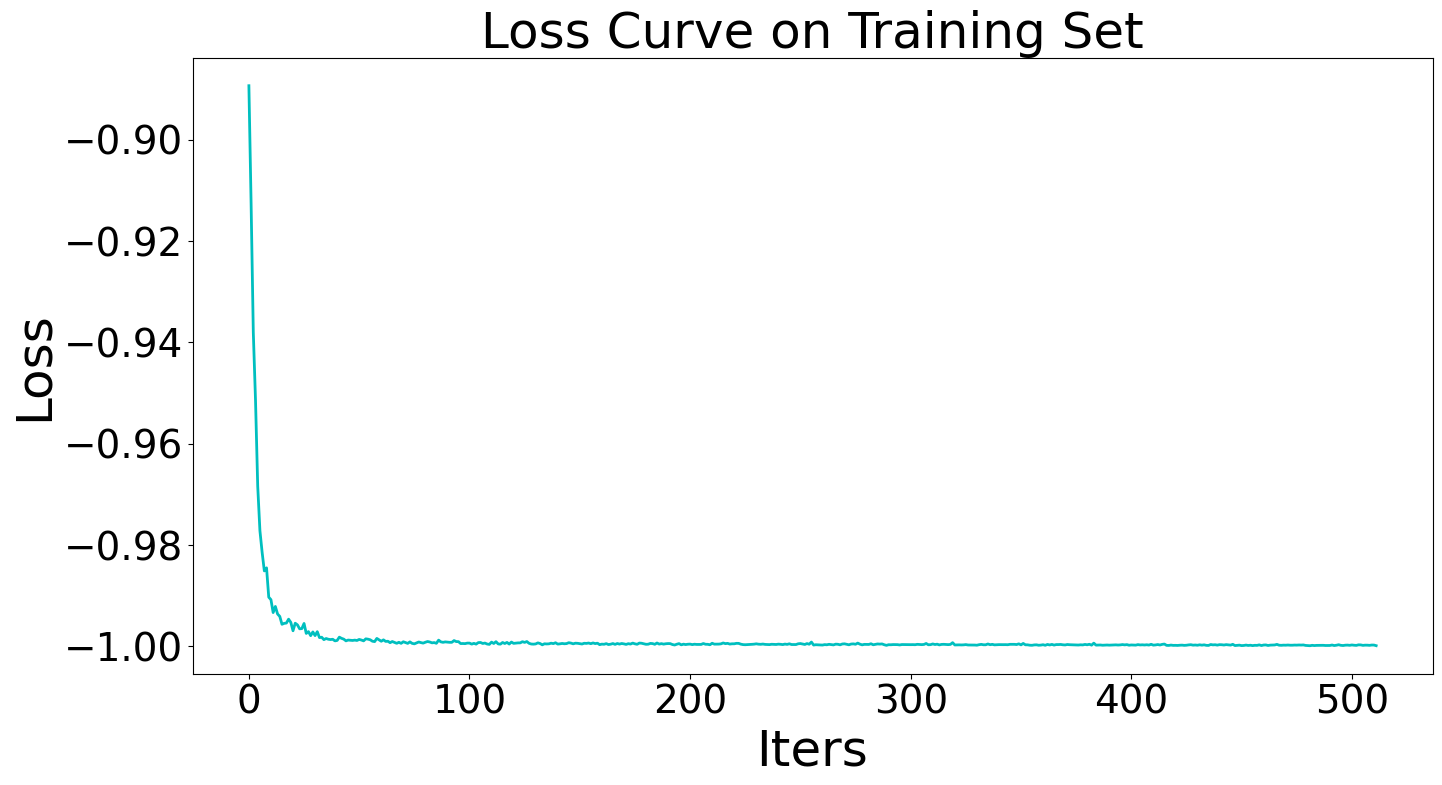

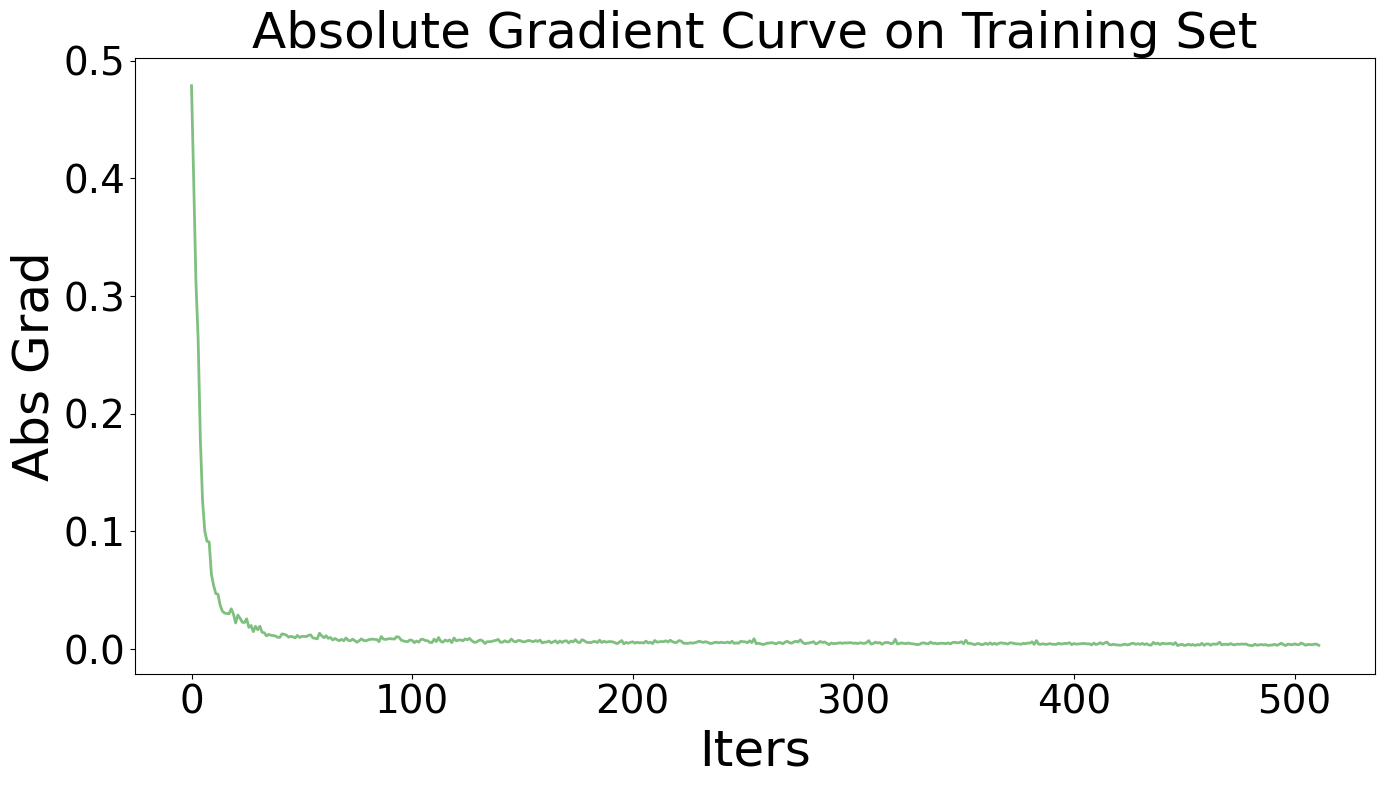

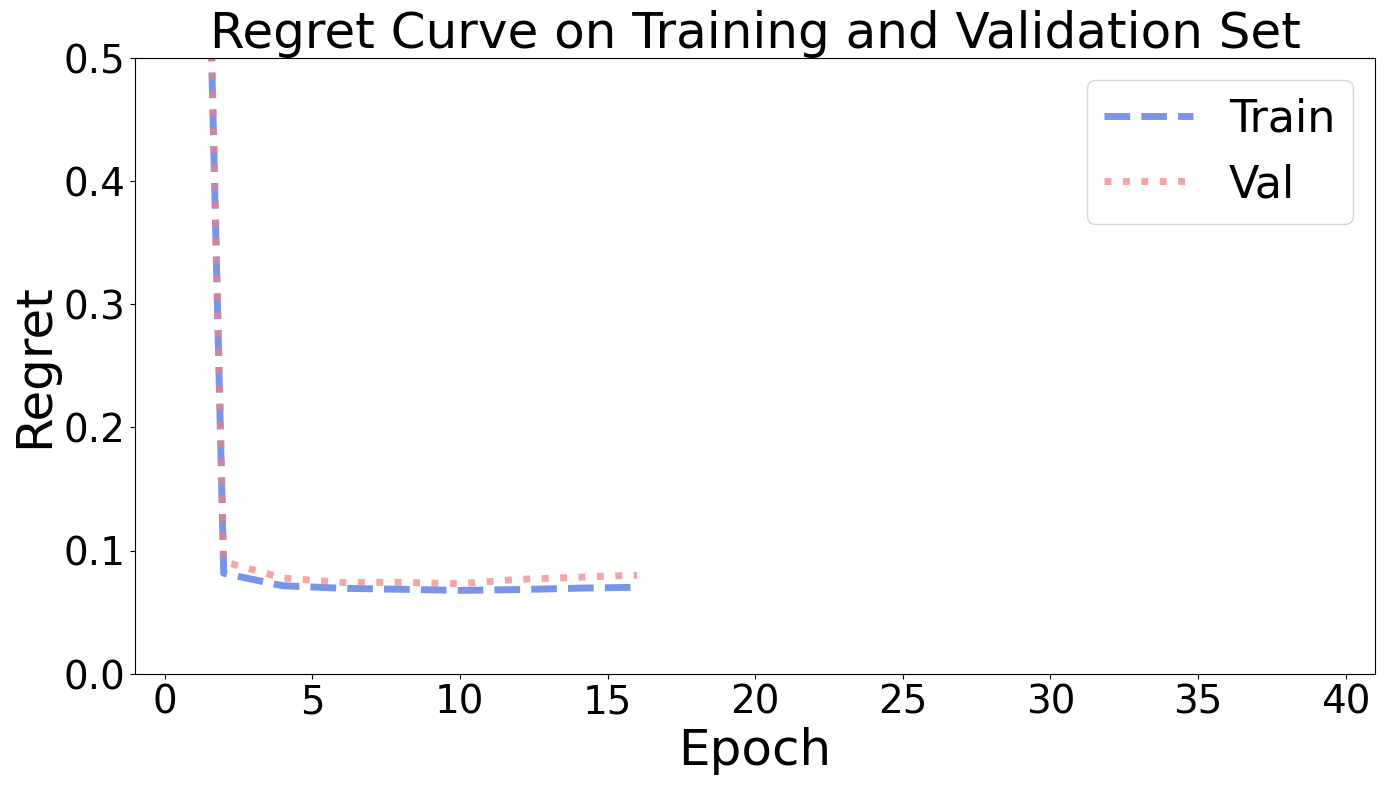

In [19]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Exact Method with NNLS

In [20]:
# init model
reg = LinearRegression()

In [21]:
from func import exactConeAlignedCosine
# init loss
ca_cos = exactConeAlignedCosine(optmodel, solver="nnls", processes=8)

Num of cores: 8


In [22]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 191.9089%, Val Regret: 200.1024%


Epoch    1, Loss:  -0.9991:   5%|██▊                                                    | 2/40 [00:24<04:20,  6.87s/it]

Epoch   2, Train Regret:   7.7129%, Val Regret:   8.9091%


Epoch    3, Loss:  -0.9992:  10%|█████▌                                                 | 4/40 [00:40<04:06,  6.85s/it]

Epoch   4, Train Regret:   7.0509%, Val Regret:   8.0657%


Epoch    5, Loss:  -0.9995:  15%|████████▎                                              | 6/40 [00:55<03:54,  6.90s/it]

Epoch   6, Train Regret:   6.8394%, Val Regret:   8.2194%


Epoch    7, Loss:  -0.9993:  20%|███████████                                            | 8/40 [01:10<03:39,  6.85s/it]

Epoch   8, Train Regret:   6.8389%, Val Regret:   7.8940%


Epoch    9, Loss:  -0.9993:  25%|█████████████▌                                        | 10/40 [01:25<03:24,  6.82s/it]

Epoch  10, Train Regret:   6.8650%, Val Regret:   7.5691%


Epoch   11, Loss:  -0.9993:  30%|████████████████▏                                     | 12/40 [01:41<03:11,  6.82s/it]

Epoch  12, Train Regret:   6.8582%, Val Regret:   7.6119%


Epoch   13, Loss:  -0.9998:  35%|██████████████████▉                                   | 14/40 [01:56<02:57,  6.82s/it]

Epoch  14, Train Regret:   7.0846%, Val Regret:   7.5676%


Epoch   15, Loss:  -0.9999:  40%|█████████████████████▌                                | 16/40 [02:11<02:44,  6.84s/it]

Epoch  16, Train Regret:   6.9104%, Val Regret:   7.5400%


Epoch   17, Loss:  -0.9998:  45%|████████████████████████▎                             | 18/40 [02:27<02:30,  6.84s/it]

Epoch  18, Train Regret:   7.2564%, Val Regret:   7.7741%


Epoch   19, Loss:  -0.9997:  50%|███████████████████████████                           | 20/40 [02:42<02:16,  6.80s/it]

Epoch  20, Train Regret:   7.1838%, Val Regret:   7.7654%


Epoch   21, Loss:  -0.9999:  55%|█████████████████████████████▋                        | 22/40 [02:57<02:01,  6.74s/it]

Epoch  22, Train Regret:   7.2000%, Val Regret:   7.4614%


Epoch   23, Loss:  -0.9998:  60%|████████████████████████████████▍                     | 24/40 [03:12<01:47,  6.70s/it]

Epoch  24, Train Regret:   7.3402%, Val Regret:   7.8683%


Epoch   25, Loss:  -0.9999:  65%|███████████████████████████████████                   | 26/40 [03:27<01:34,  6.76s/it]

Epoch  26, Train Regret:   7.3026%, Val Regret:   7.6401%


Epoch   27, Loss:  -0.9998:  70%|█████████████████████████████████████▊                | 28/40 [03:42<01:35,  7.95s/it]


Epoch  28, Train Regret:   7.3931%, Val Regret:   7.5846%

Early Stop!

Evaluation:
Test Regret: 8.2876%
Training Elapsed Time: 55.97 Sec


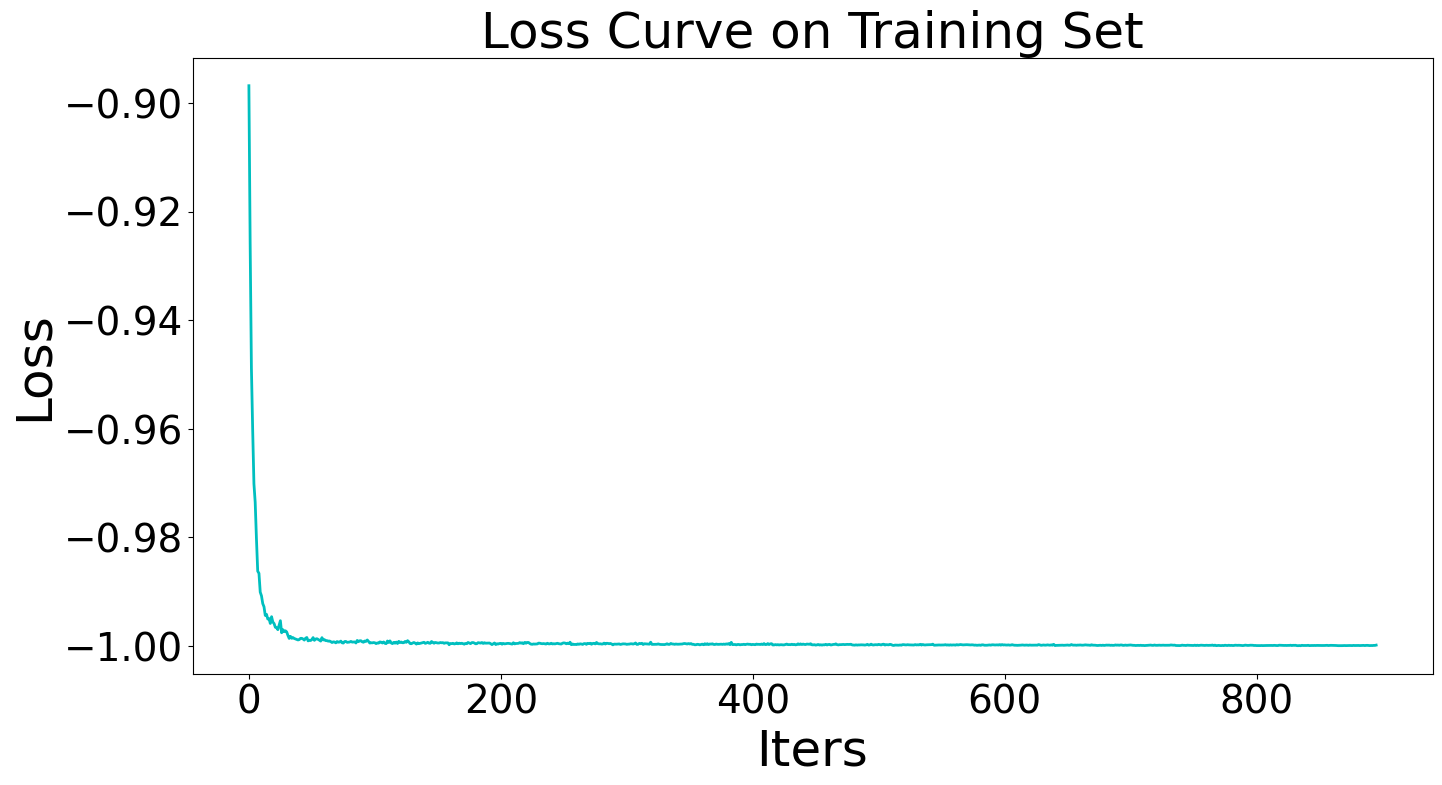

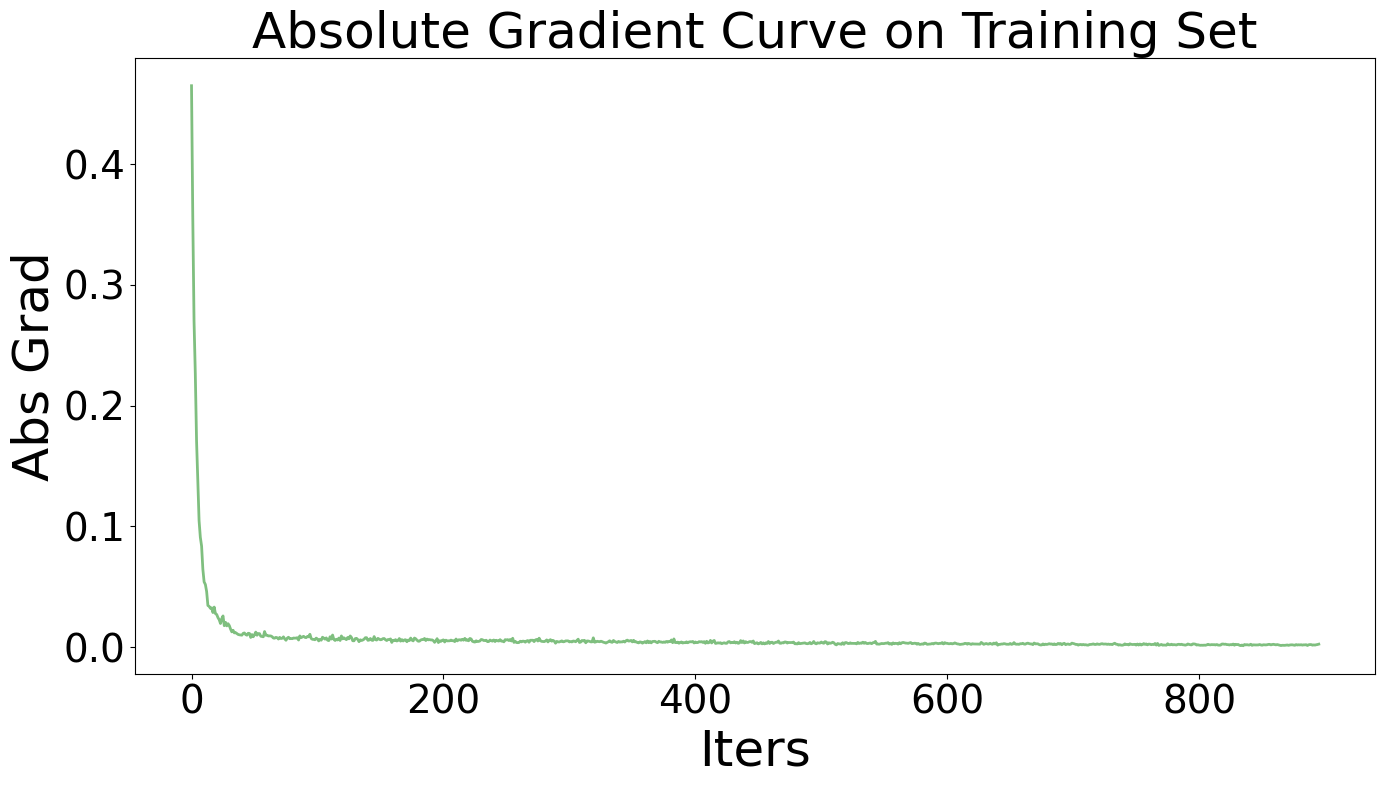

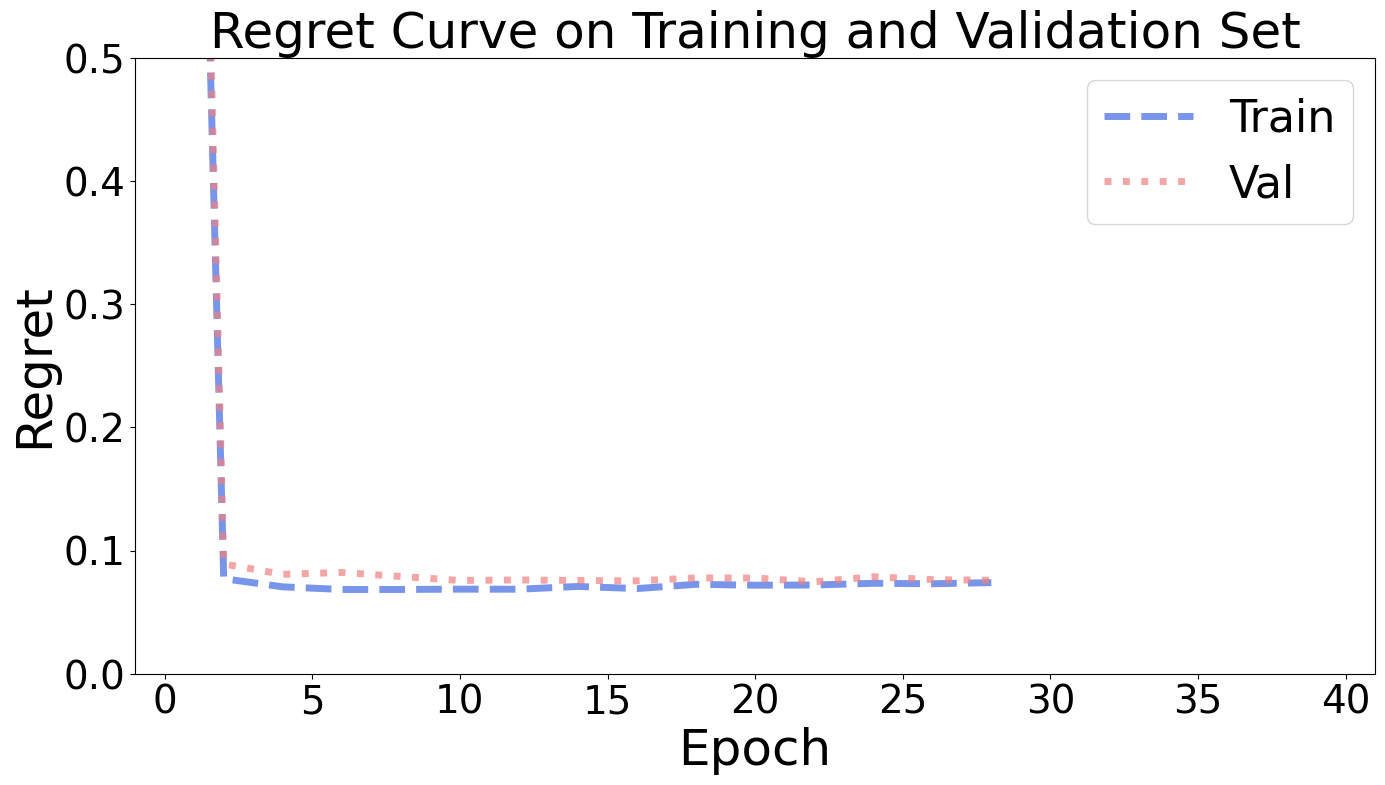

In [23]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sampling Method

In [24]:
# init model
reg = LinearRegression()

In [25]:
from func import samplingConeAlignedCosine
# init loss
ca_cos = samplingConeAlignedCosine(optmodel, n_samples=100)

In [26]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 209.2889%, Val Regret: 222.9967%


Epoch    1, Loss:  -0.7338:   5%|██▊                                                    | 2/40 [00:22<03:48,  6.00s/it]

Epoch   2, Train Regret:  15.4398%, Val Regret:  15.9313%


Epoch    3, Loss:  -0.7756:  10%|█████▌                                                 | 4/40 [00:36<03:32,  5.92s/it]

Epoch   4, Train Regret:  14.8626%, Val Regret:  15.9401%


Epoch    5, Loss:  -0.7865:  15%|████████▎                                              | 6/40 [00:49<03:21,  5.91s/it]

Epoch   6, Train Regret:  14.5455%, Val Regret:  15.3748%


Epoch    7, Loss:  -0.7226:  20%|███████████                                            | 8/40 [01:03<03:07,  5.86s/it]

Epoch   8, Train Regret:  14.6805%, Val Regret:  14.8106%


Epoch    9, Loss:  -0.7360:  25%|█████████████▌                                        | 10/40 [01:16<02:56,  5.88s/it]

Epoch  10, Train Regret:  14.2067%, Val Regret:  13.8430%


Epoch   11, Loss:  -0.7629:  30%|████████████████▏                                     | 12/40 [01:29<02:43,  5.85s/it]

Epoch  12, Train Regret:  14.3302%, Val Regret:  13.8042%


Epoch   13, Loss:  -0.7515:  35%|██████████████████▉                                   | 14/40 [01:43<02:32,  5.88s/it]

Epoch  14, Train Regret:  13.8351%, Val Regret:  13.3149%


Epoch   15, Loss:  -0.7886:  40%|█████████████████████▌                                | 16/40 [01:56<02:21,  5.91s/it]

Epoch  16, Train Regret:  14.0165%, Val Regret:  14.0834%


Epoch   17, Loss:  -0.7739:  45%|████████████████████████▎                             | 18/40 [02:10<02:10,  5.95s/it]

Epoch  18, Train Regret:  13.7158%, Val Regret:  14.0321%


Epoch   19, Loss:  -0.7761:  50%|███████████████████████████                           | 20/40 [02:24<02:24,  7.21s/it]


Epoch  20, Train Regret:  13.9354%, Val Regret:  14.0994%

Early Stop!

Evaluation:
Test Regret: 14.3938%
Training Elapsed Time: 21.60 Sec


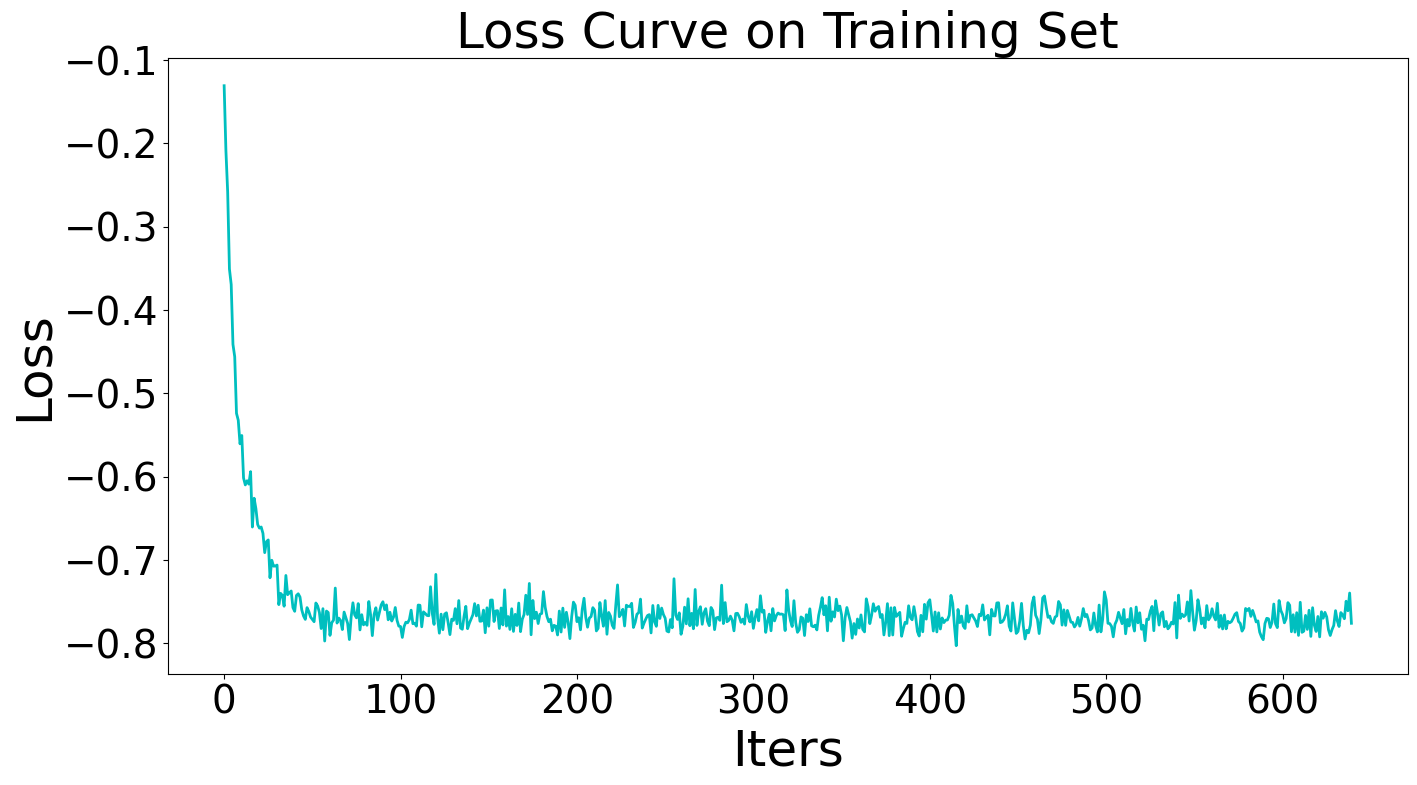

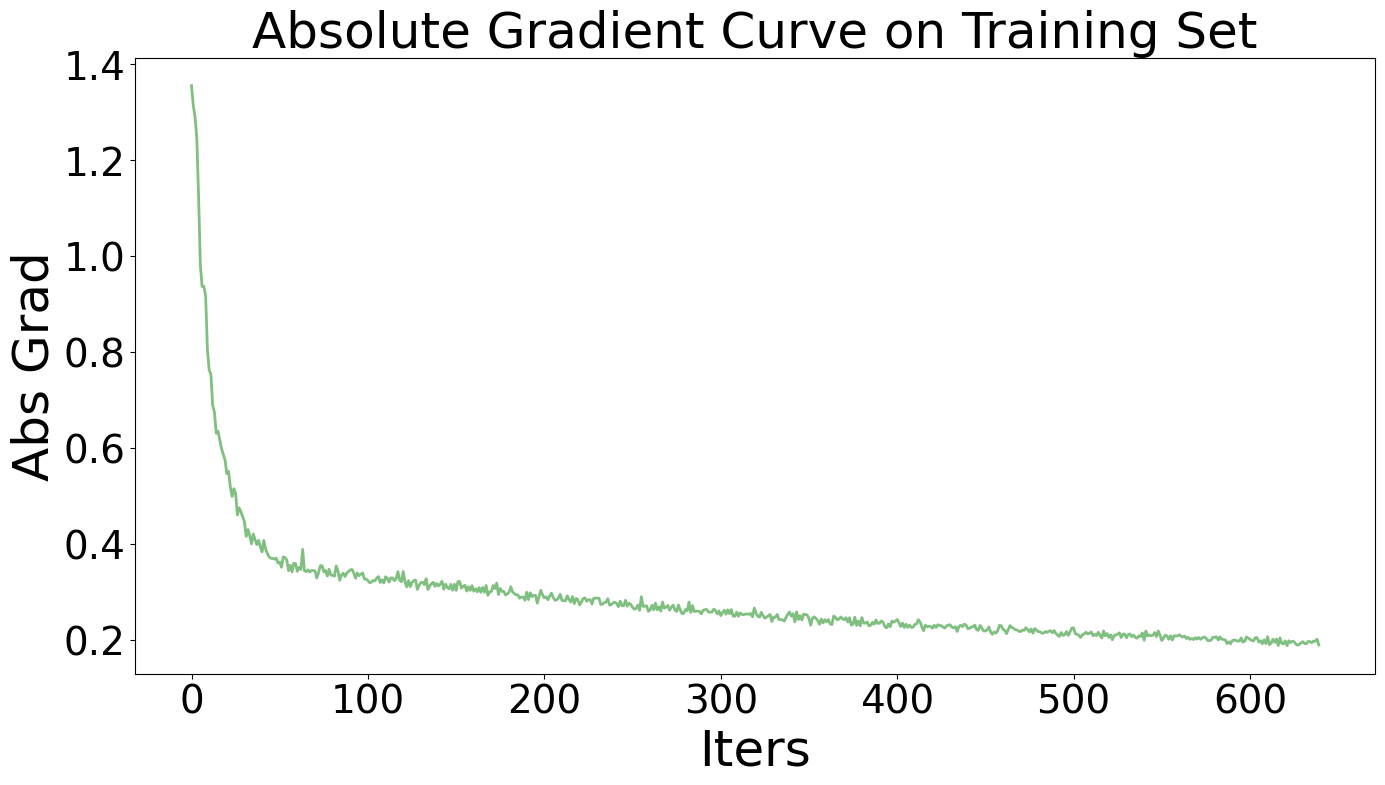

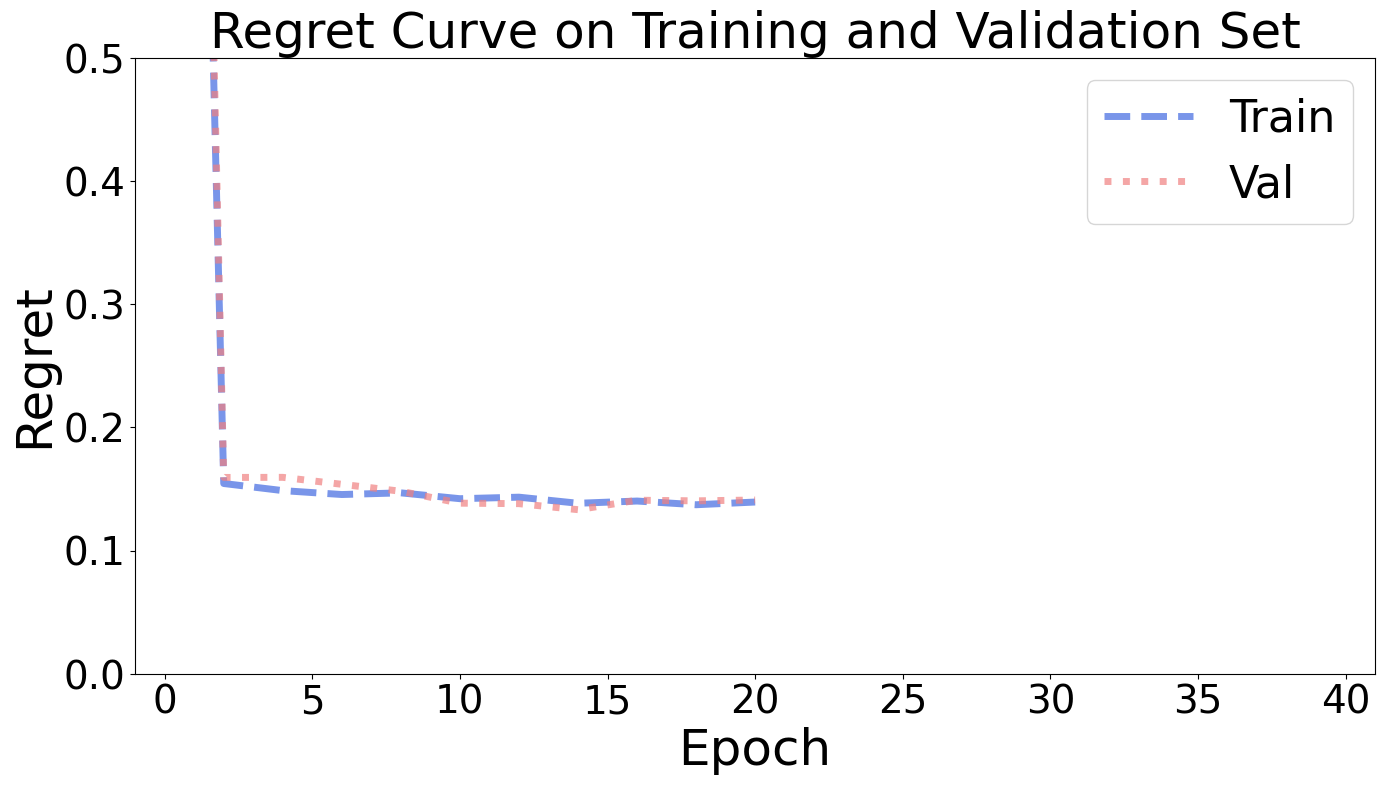

In [27]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Average Method 

In [28]:
# init model
reg = LinearRegression()

In [29]:
from func import avgConeAlignedCosine
# init loss
ca_cos = avgConeAlignedCosine(optmodel)

In [30]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 201.8660%, Val Regret: 209.2473%


Epoch    1, Loss:  -0.6211:   5%|██▊                                                    | 2/40 [00:20<03:08,  4.97s/it]

Epoch   2, Train Regret:  13.5171%, Val Regret:  13.3372%


Epoch    3, Loss:  -0.7054:  10%|█████▌                                                 | 4/40 [00:32<03:01,  5.04s/it]

Epoch   4, Train Regret:  13.0291%, Val Regret:  13.8360%


Epoch    5, Loss:  -0.8115:  15%|████████▎                                              | 6/40 [00:45<02:54,  5.14s/it]

Epoch   6, Train Regret:  13.4941%, Val Regret:  13.7431%


Epoch    7, Loss:  -0.6522:  20%|███████████                                            | 8/40 [00:56<03:47,  7.12s/it]


Epoch   8, Train Regret:  13.2351%, Val Regret:  13.6566%

Early Stop!

Evaluation:
Test Regret: 13.7143%
Training Elapsed Time: 1.79 Sec


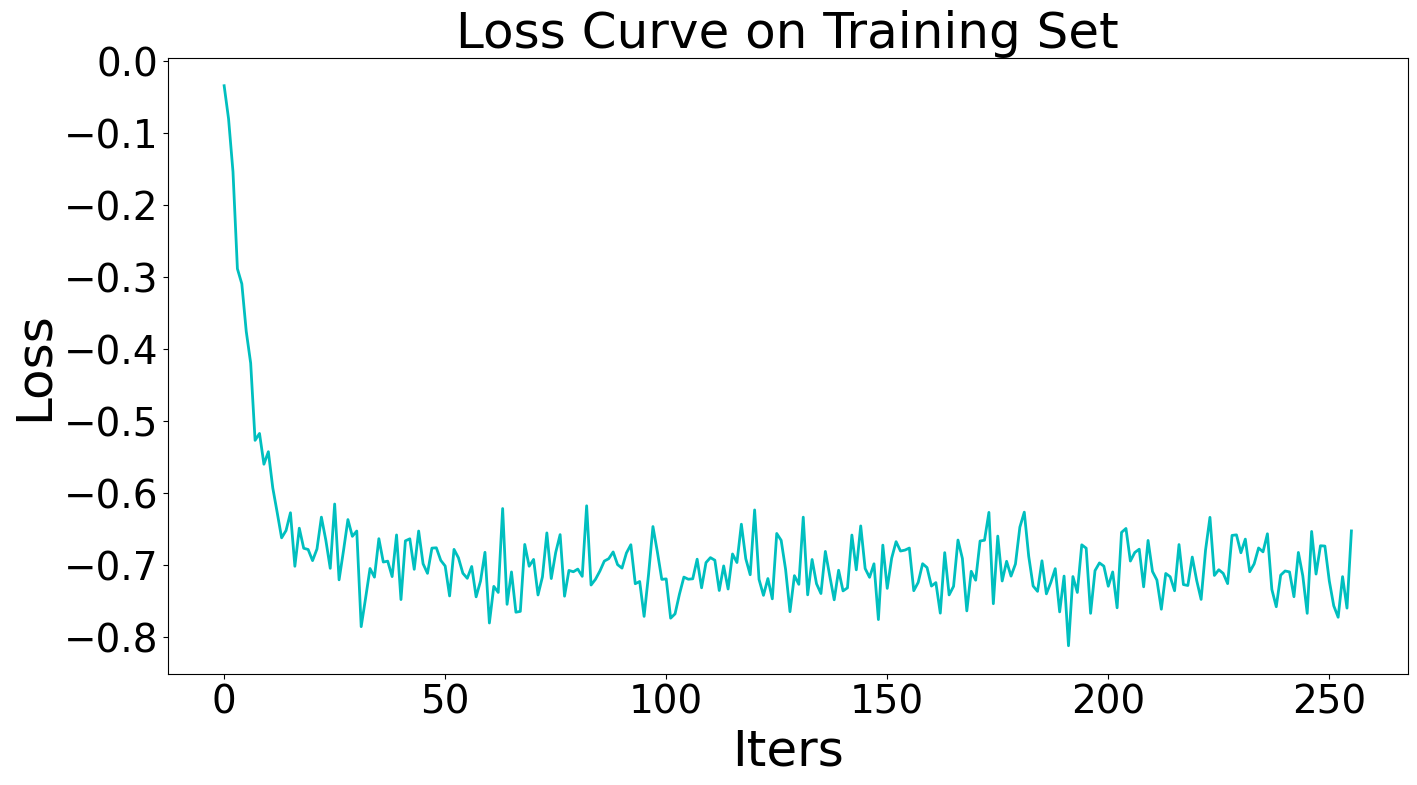

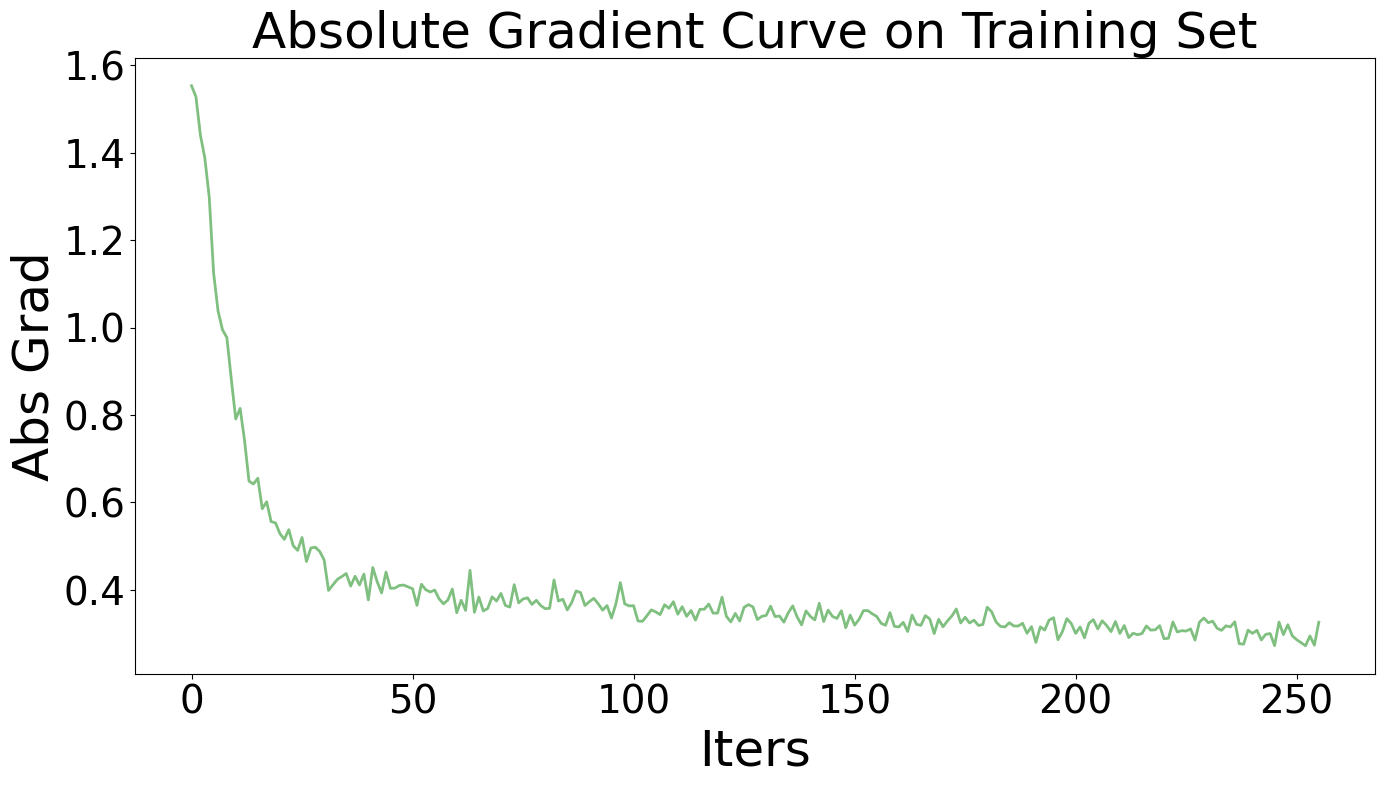

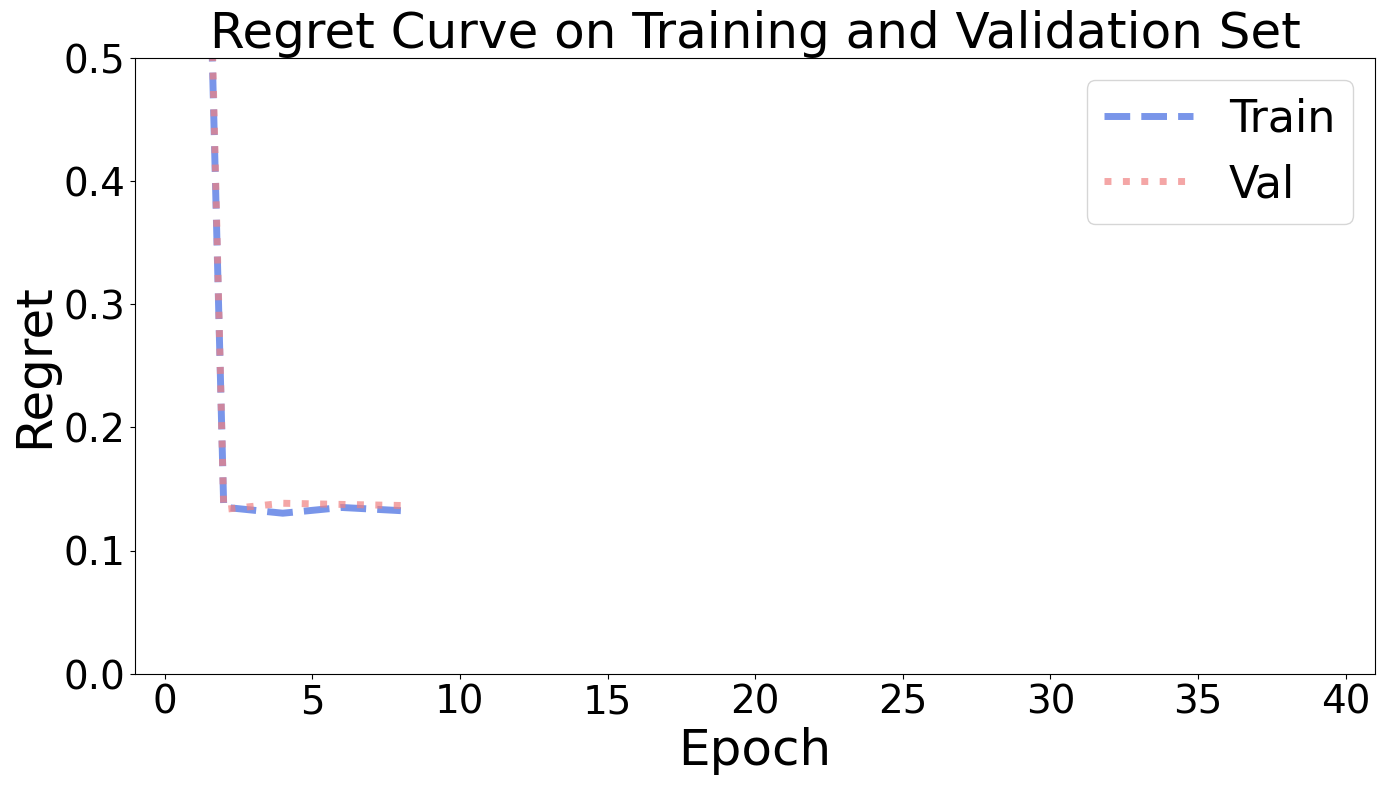

In [31]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### Sign Method 

In [32]:
# init model
reg = LinearRegression()

In [33]:
from func import signConeAlignedCosine
# init loss
ca_cos = signConeAlignedCosine(optmodel)

In [34]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardCAVE, ca_cos, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 191.5249%, Val Regret: 196.4433%


Epoch    1, Loss:  -0.9946:   5%|██▊                                                    | 2/40 [00:20<03:11,  5.04s/it]

Epoch   2, Train Regret:  15.6103%, Val Regret:  17.1117%


Epoch    3, Loss:  -0.9957:  10%|█████▌                                                 | 4/40 [00:32<02:59,  4.98s/it]

Epoch   4, Train Regret:  14.3712%, Val Regret:  16.9513%


Epoch    5, Loss:  -0.9966:  15%|████████▎                                              | 6/40 [00:43<02:49,  4.97s/it]

Epoch   6, Train Regret:  14.4037%, Val Regret:  15.5818%


Epoch    7, Loss:  -0.9968:  20%|███████████                                            | 8/40 [00:55<02:38,  4.94s/it]

Epoch   8, Train Regret:  15.5002%, Val Regret:  17.3799%


Epoch    9, Loss:  -0.9959:  25%|█████████████▌                                        | 10/40 [01:06<02:27,  4.93s/it]

Epoch  10, Train Regret:  17.5337%, Val Regret:  20.2948%


Epoch   11, Loss:  -0.9975:  30%|████████████████▏                                     | 12/40 [01:18<03:02,  6.52s/it]


Epoch  12, Train Regret:  22.0020%, Val Regret:  23.0667%

Early Stop!

Evaluation:
Test Regret: 22.6798%
Training Elapsed Time: 2.79 Sec


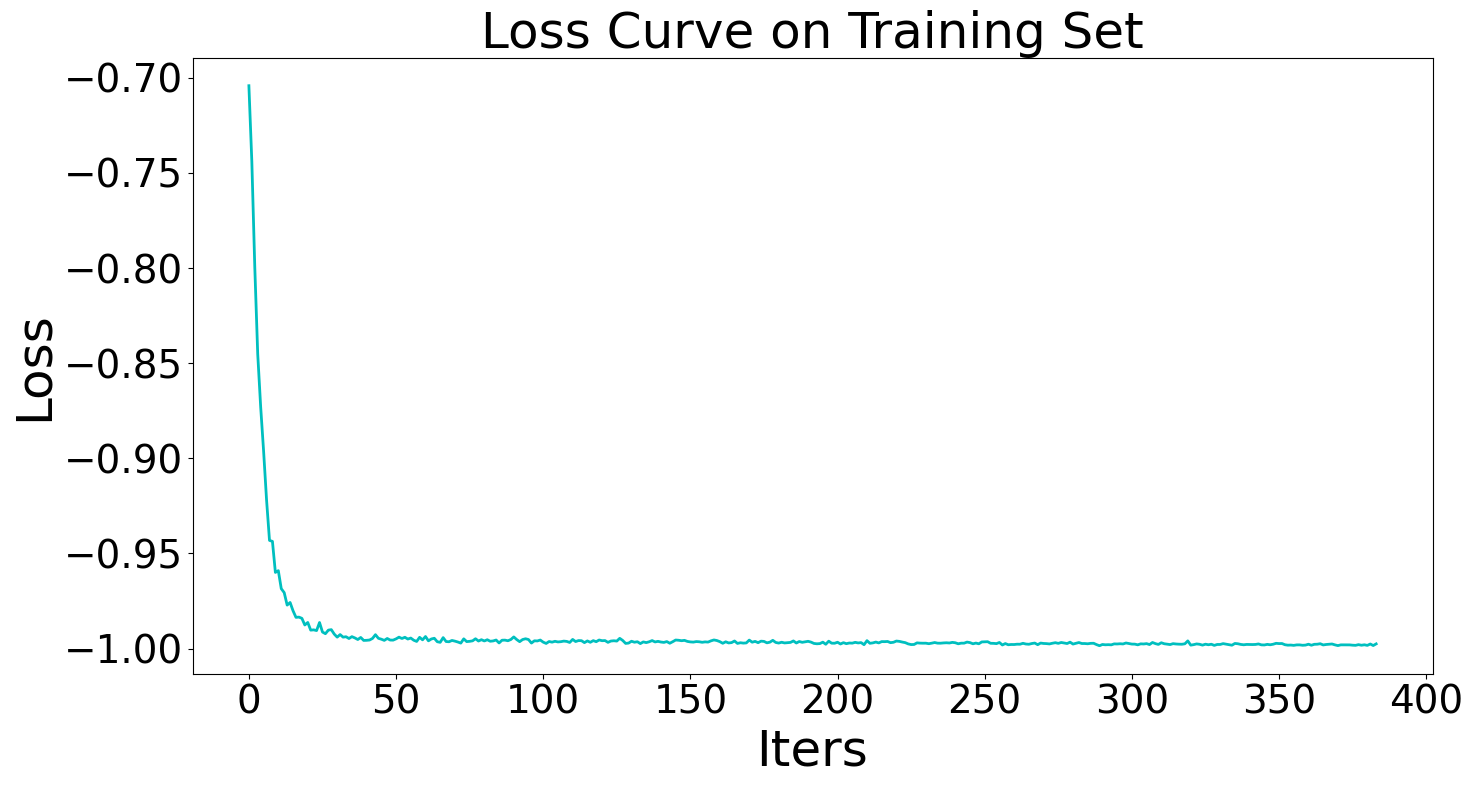

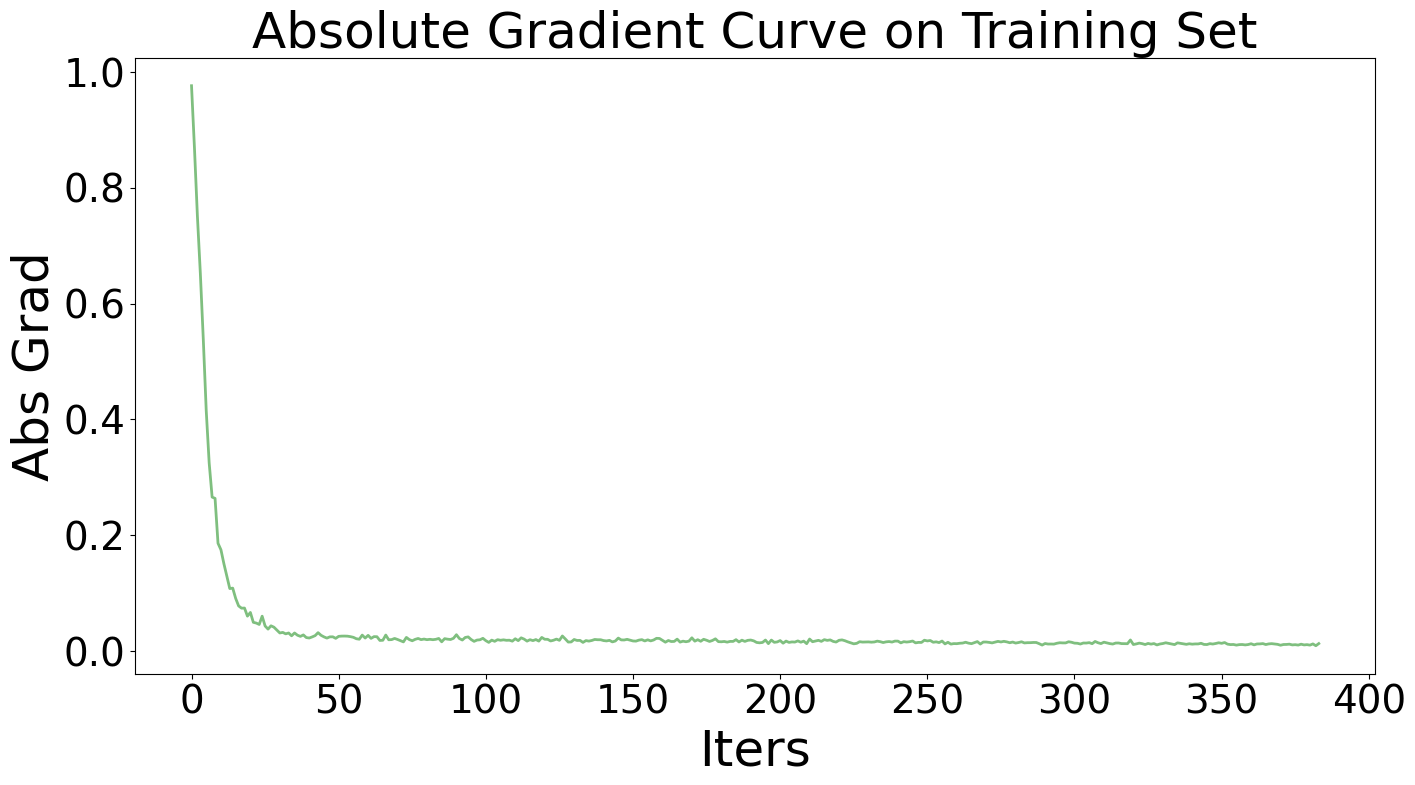

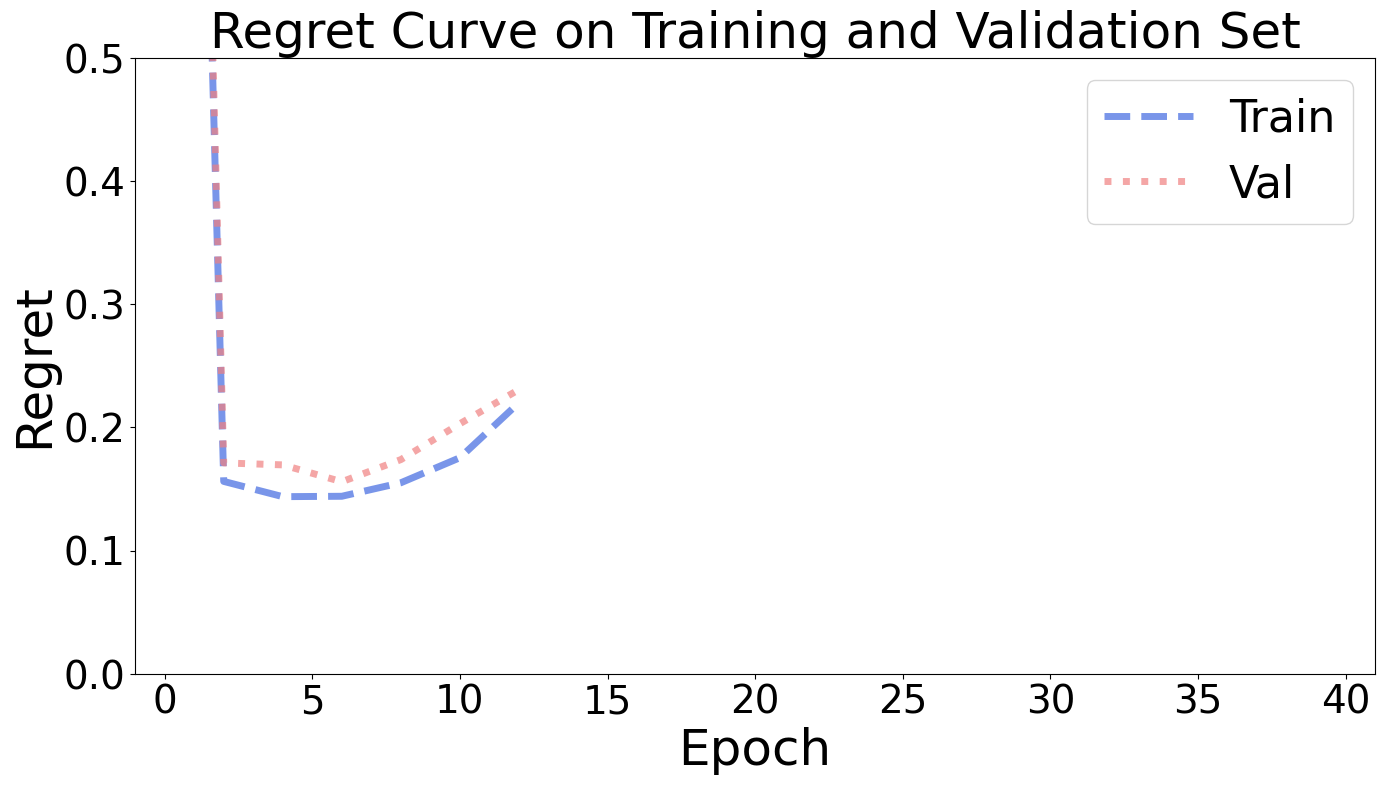

In [35]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### PFYL 

In [36]:
# init model
reg = LinearRegression()

In [37]:
from pyepo.func import perturbedFenchelYoung
# init pfyl loss
pfy = perturbedFenchelYoung(optmodel, n_samples=1, sigma=1.0, processes=8)

def forwardPFY(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [38]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardPFY, pfy, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 188.6889%, Val Regret: 190.3790%


Epoch    1, Loss:  19.5000:   5%|██▊                                                    | 2/40 [00:25<04:37,  7.29s/it]

Epoch   2, Train Regret:   7.0845%, Val Regret:   7.2285%


Epoch    3, Loss:  15.2500:  10%|█████▌                                                 | 4/40 [00:41<04:22,  7.29s/it]

Epoch   4, Train Regret:   6.2264%, Val Regret:   7.1511%


Epoch    5, Loss:  16.0000:  15%|████████▎                                              | 6/40 [00:59<04:20,  7.66s/it]

Epoch   6, Train Regret:   6.0214%, Val Regret:   6.3282%


Epoch    7, Loss:  16.5000:  20%|███████████                                            | 8/40 [01:16<04:06,  7.72s/it]

Epoch   8, Train Regret:   5.9993%, Val Regret:   7.2972%


Epoch    9, Loss:  15.2500:  25%|█████████████▌                                        | 10/40 [01:33<03:47,  7.60s/it]

Epoch  10, Train Regret:   5.9127%, Val Regret:   7.0160%


Epoch   11, Loss:  16.2500:  30%|████████████████▏                                     | 12/40 [01:50<04:18,  9.22s/it]


Epoch  12, Train Regret:   5.9228%, Val Regret:   6.3757%

Early Stop!

Evaluation:
Test Regret: 6.6383%
Training Elapsed Time: 32.49 Sec


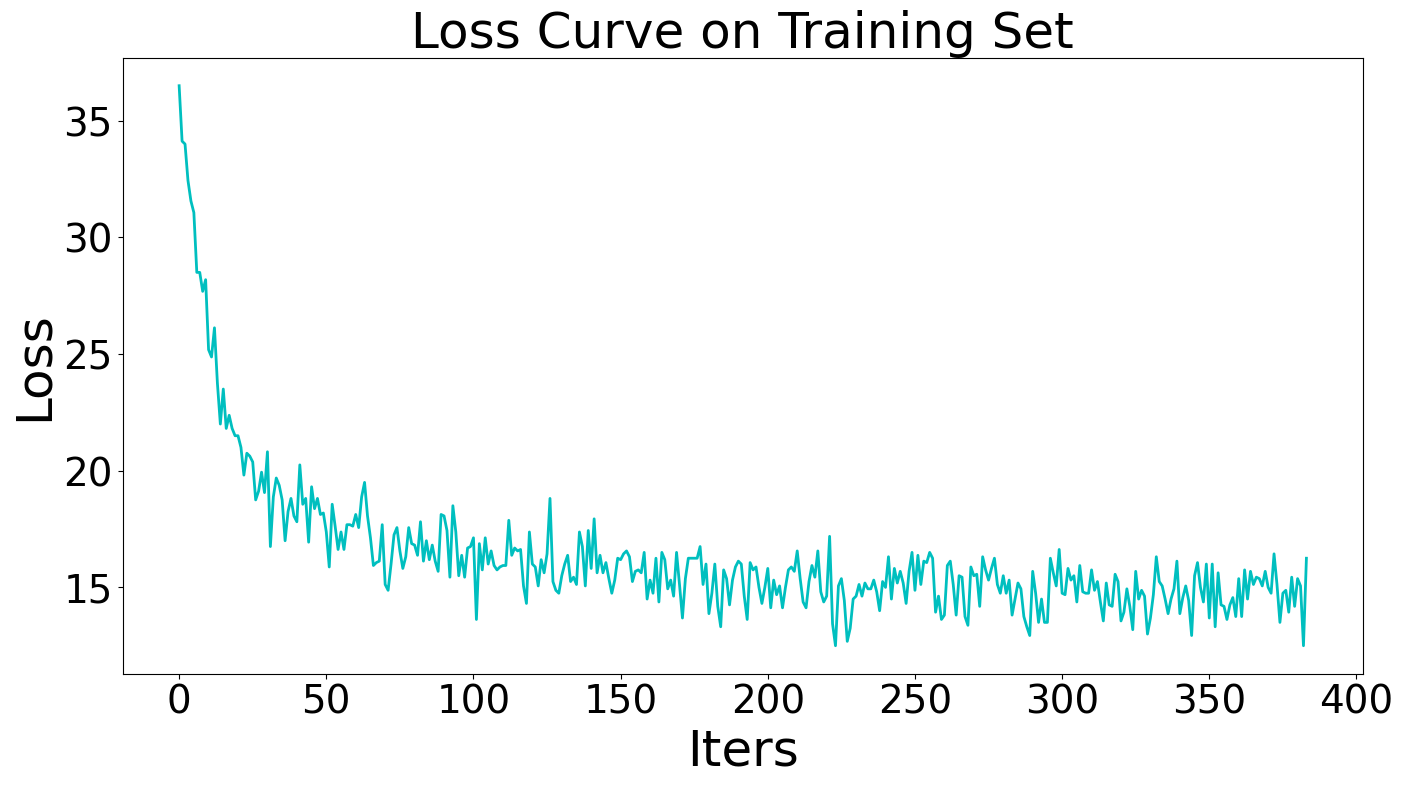

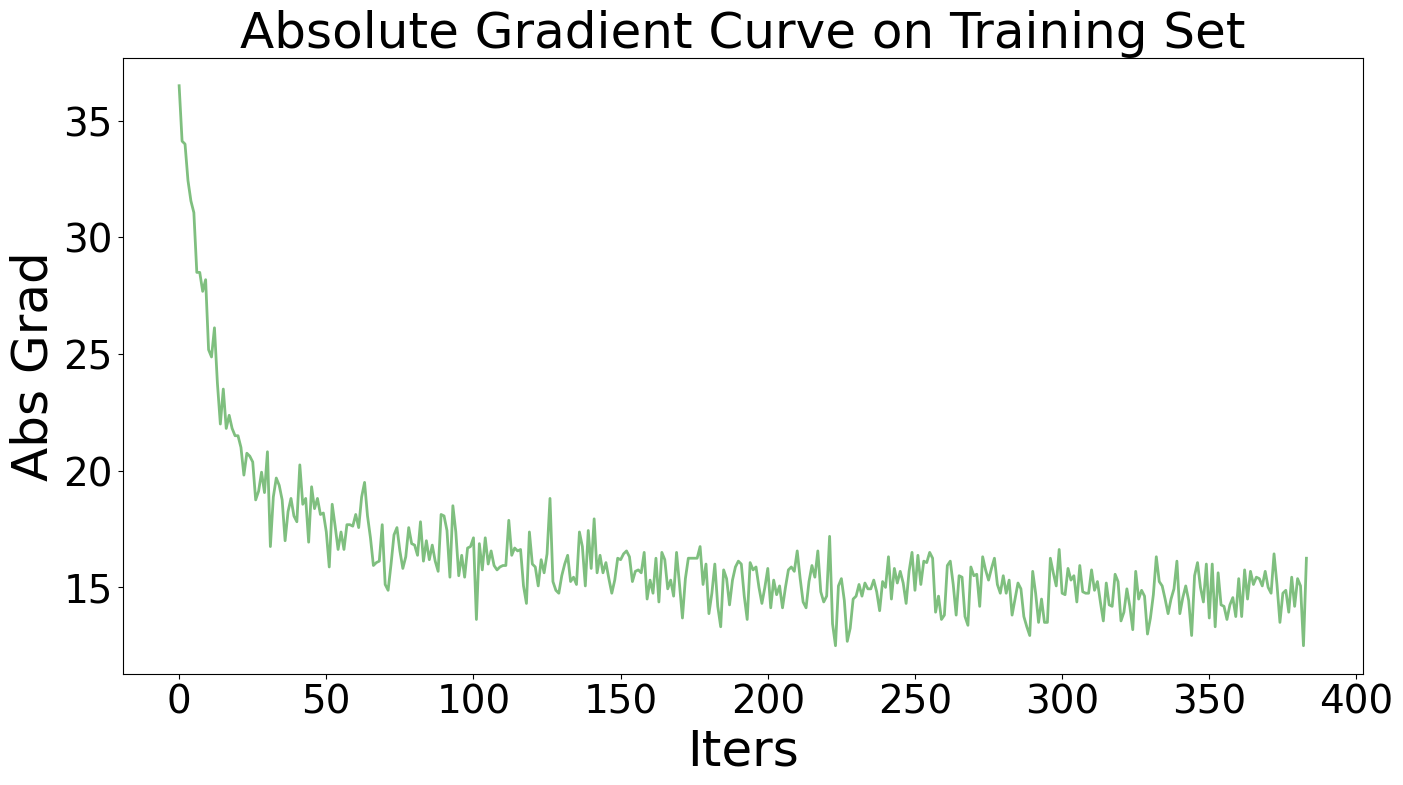

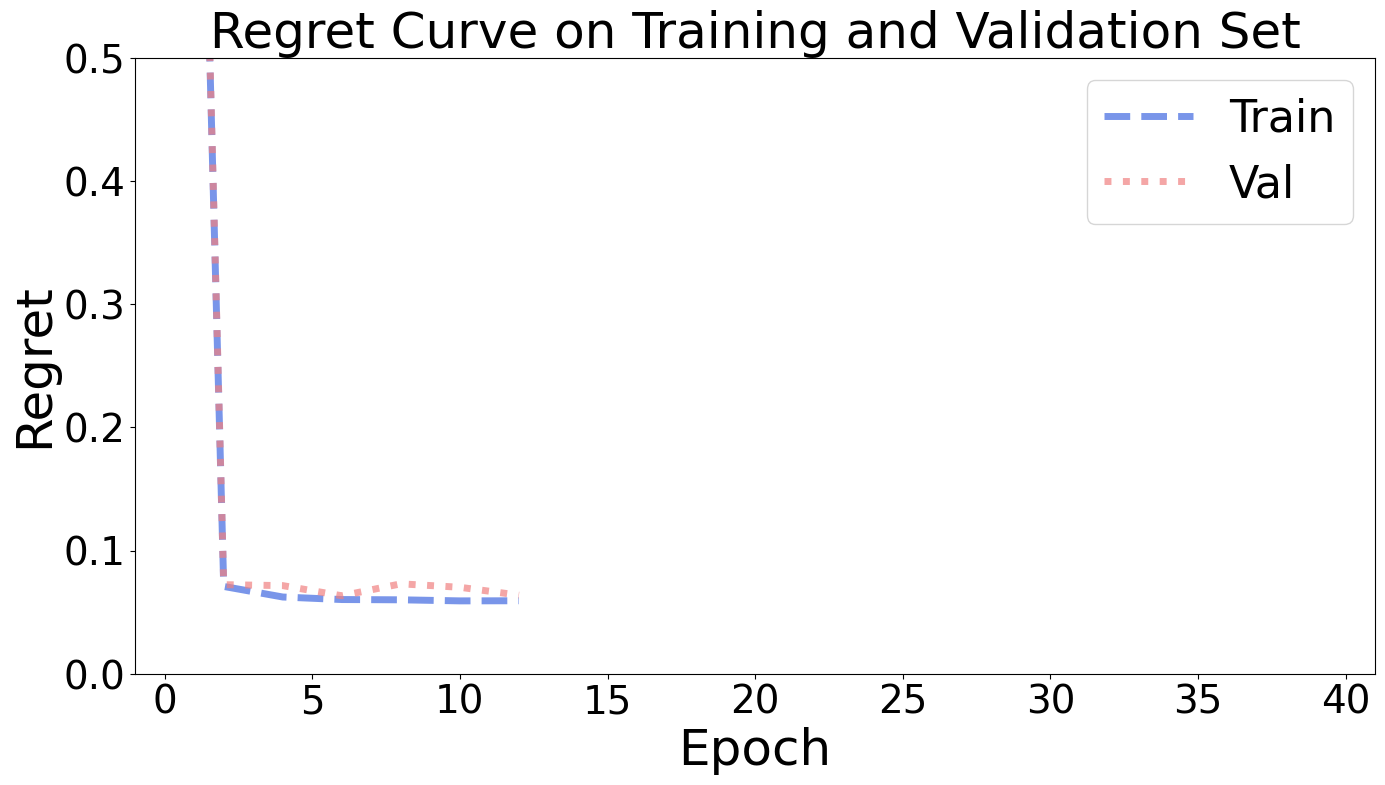

In [39]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)

### NCE 

In [40]:
# init model
reg = LinearRegression()

In [41]:
from pyepo.func import NCE
# init nce loss
nce = NCE(optmodel, processes=8, solve_ratio=0.05, dataset=dataset_train_cost)

def forwardNCE(data, reg, loss_func, grad_log):
    # unzip data
    x, _, w, _ = data
    # predict
    cp = reg(x)
    # get gradient
    cp.register_hook(lambda grad: grad_log.append(abs(grad.cpu().detach().numpy()).sum()))
    # loss
    loss = loss_func(cp, w)
    return loss

Num of cores: 8


In [42]:
loss_log, grad_log, regret_log_trn, regret_log_val = pipeline(reg, forwardNCE, nce, lr, num_epochs, log_step,
                                                              loader_train, loader_val, loader_test)

  0%|                                                                                           | 0/40 [00:09<?, ?it/s]

Epoch   0, Train Regret: 188.6889%, Val Regret: 190.3790%


Epoch    1, Loss: -119.1756:   5%|██▋                                                   | 2/40 [00:21<03:19,  5.25s/it]

Epoch   2, Train Regret:  15.5144%, Val Regret:  16.9080%


Epoch    3, Loss: -245.6877:  10%|█████▍                                                | 4/40 [00:33<03:05,  5.16s/it]

Epoch   4, Train Regret:  14.0713%, Val Regret:  14.7658%


Epoch    5, Loss: -488.9224:  15%|████████                                              | 6/40 [00:45<02:55,  5.16s/it]

Epoch   6, Train Regret:  13.0268%, Val Regret:  15.3051%


Epoch    7, Loss: -492.1133:  20%|██████████▊                                           | 8/40 [00:57<02:46,  5.20s/it]

Epoch   8, Train Regret:  12.5704%, Val Regret:  14.0339%


Epoch    9, Loss: -615.2303:  25%|█████████████▎                                       | 10/40 [01:09<02:36,  5.23s/it]

Epoch  10, Train Regret:  12.2672%, Val Regret:  13.7281%


Epoch   11, Loss: -756.9047:  30%|███████████████▉                                     | 12/40 [01:21<02:28,  5.30s/it]

Epoch  12, Train Regret:  11.8776%, Val Regret:  13.2620%


Epoch   13, Loss: -1020.7313:  35%|██████████████████▏                                 | 14/40 [01:33<02:15,  5.22s/it]

Epoch  14, Train Regret:  11.5097%, Val Regret:  12.8365%


Epoch   15, Loss: -1010.6379:  40%|████████████████████▊                               | 16/40 [01:45<02:05,  5.22s/it]

Epoch  16, Train Regret:  11.3300%, Val Regret:  12.5972%


Epoch   17, Loss: -1177.8079:  45%|███████████████████████▍                            | 18/40 [01:57<01:55,  5.23s/it]

Epoch  18, Train Regret:  11.0942%, Val Regret:  12.5042%


Epoch   19, Loss: -1432.4160:  50%|██████████████████████████                          | 20/40 [02:09<01:44,  5.24s/it]

Epoch  20, Train Regret:  10.9070%, Val Regret:  12.3307%


Epoch   21, Loss: -1388.7626:  55%|████████████████████████████▌                       | 22/40 [02:21<01:32,  5.14s/it]

Epoch  22, Train Regret:  10.8736%, Val Regret:  12.3162%


Epoch   23, Loss: -1360.4871:  60%|███████████████████████████████▏                    | 24/40 [02:32<01:20,  5.04s/it]

Epoch  24, Train Regret:  10.8299%, Val Regret:  12.2268%


Epoch   25, Loss: -1895.4149:  65%|█████████████████████████████████▊                  | 26/40 [02:44<01:10,  5.04s/it]

Epoch  26, Train Regret:  10.8037%, Val Regret:  12.3309%


Epoch   27, Loss: -1980.0836:  70%|████████████████████████████████████▍               | 28/40 [02:56<01:01,  5.15s/it]

Epoch  28, Train Regret:  10.7402%, Val Regret:  12.4098%


Epoch   29, Loss: -2060.8459:  75%|███████████████████████████████████████             | 30/40 [03:08<01:02,  6.30s/it]


Epoch  30, Train Regret:  10.6782%, Val Regret:  12.3534%

Early Stop!

Evaluation:
Test Regret: 11.7227%
Training Elapsed Time: 12.77 Sec


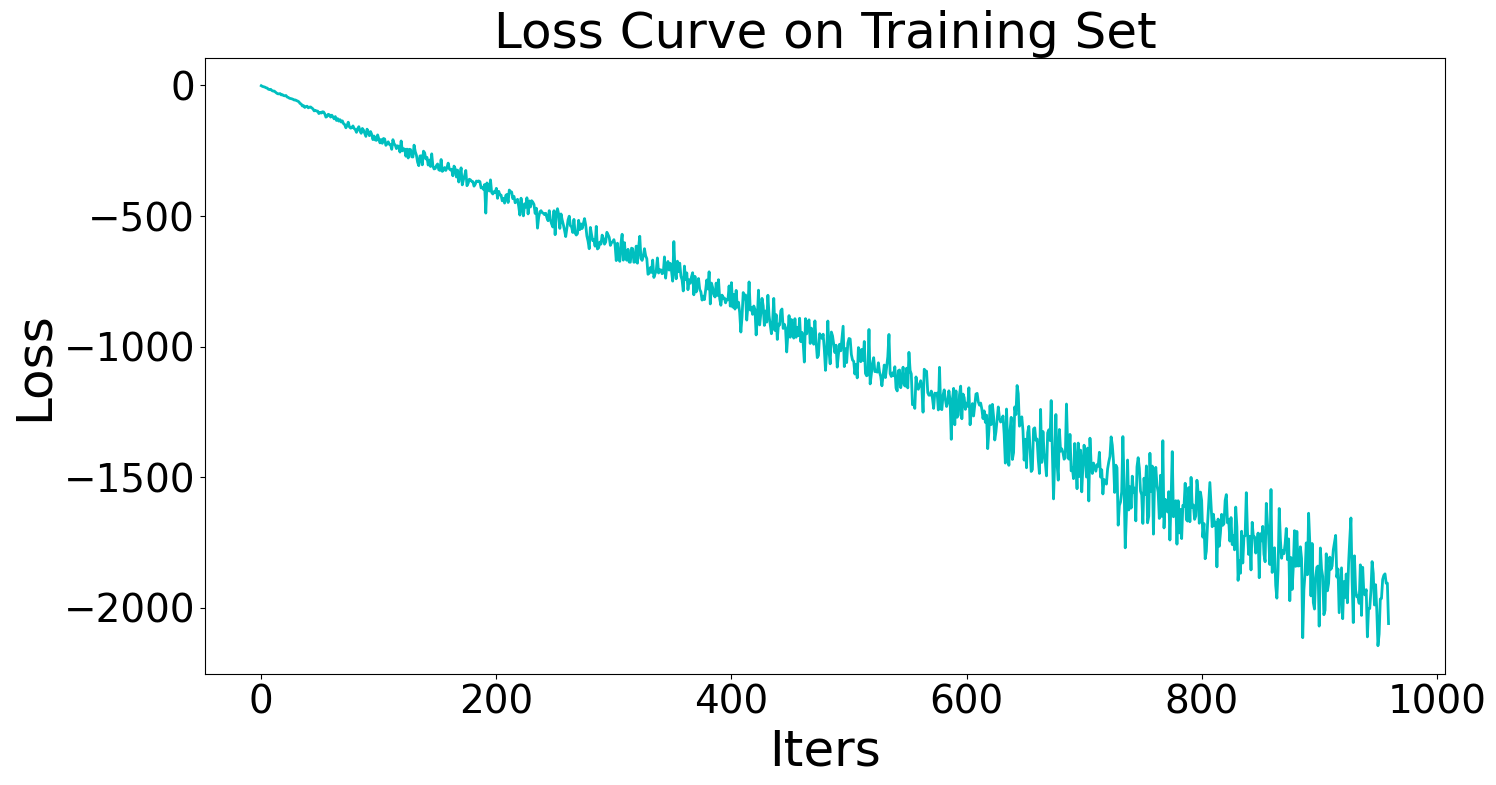

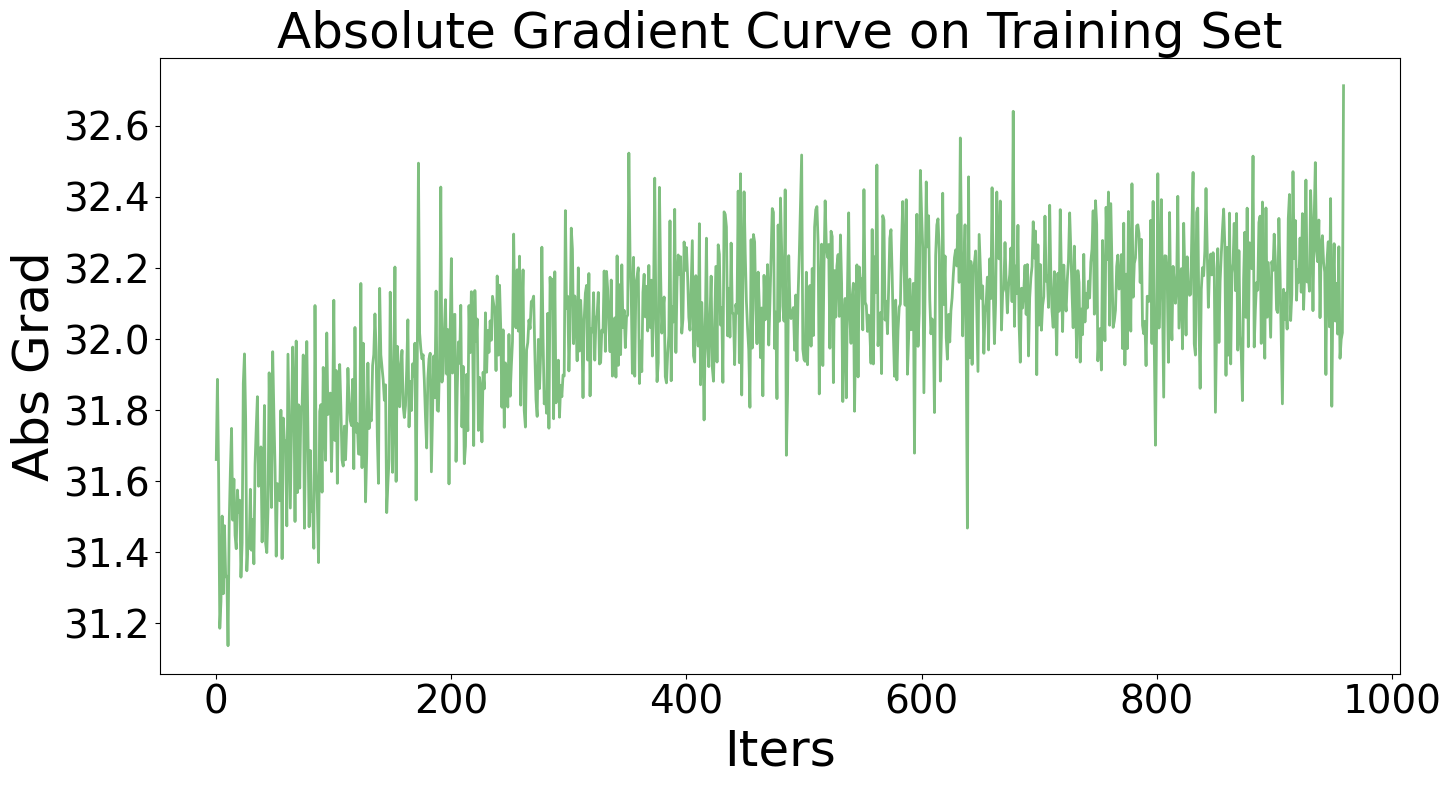

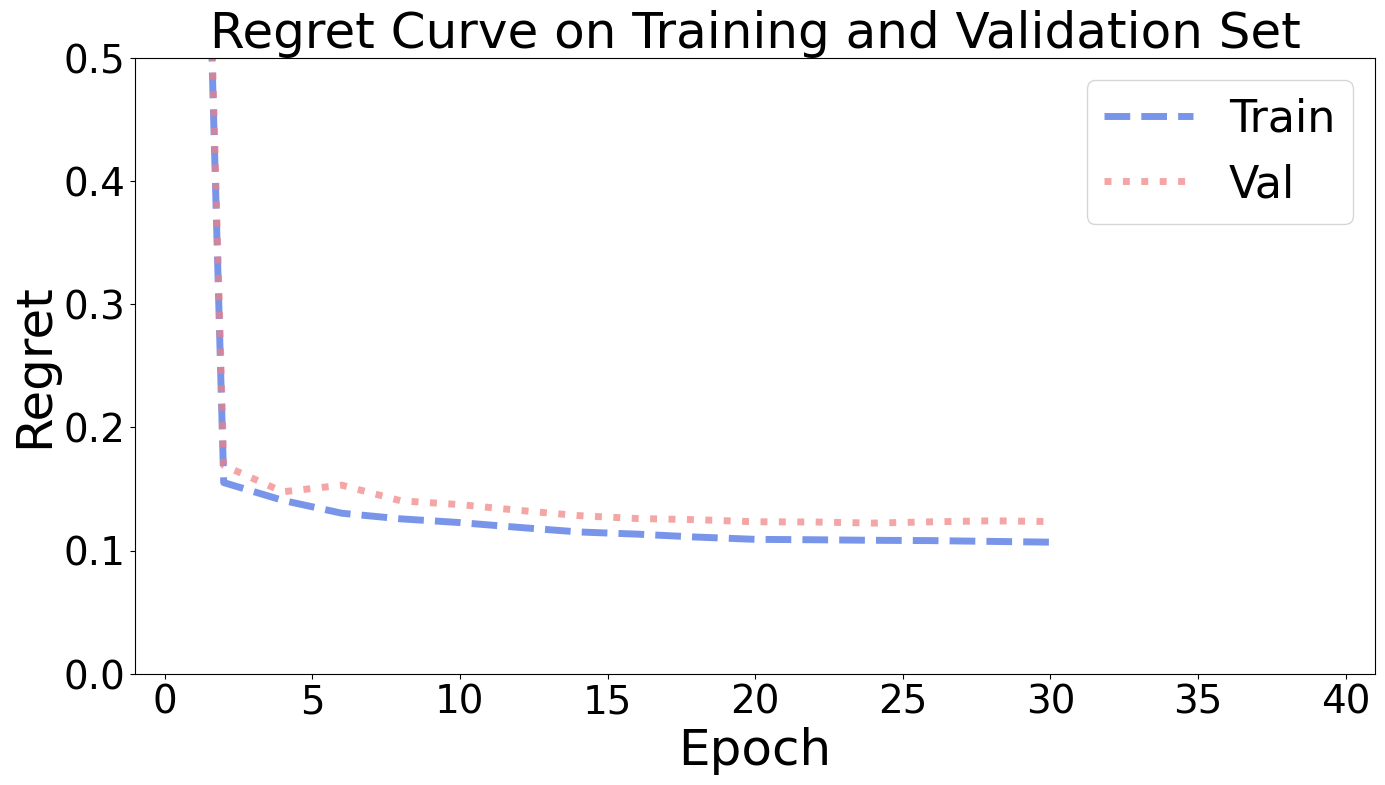

In [43]:
plot(loss_log, grad_log, regret_log_trn, regret_log_val, num_epochs, log_step)